In [1]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import random
import tqdm

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [123]:
import matplotlib.pyplot as plt

class Island:
    def __init__(self, xcentr=5, ycentr=5, radius=1):
        self.xcentr = xcentr
        self.ycentr = ycentr
        self.radius = radius

    def belongs_to_boarder(self, x, y):
        dist = ((x - self.xcentr) ** 2 + (y - self.ycentr) ** 2) ** 0.5
        if dist <= self.radius:
            return True
        else:
            return False

    def get_dist(self, x, y):
        return ((x - self.xcentr) ** 2 + (y - self.ycentr) ** 2) ** 0.5 - self.radius

    def draw_island(self, color='blue'):
        return plt.Circle((self.xcentr, self.ycentr), self.radius, color=color)

    def getCoords(self):
        return [self.xcentr, self.ycentr]


In [124]:
class Target:
    def __init__(self, xcentr=5, ycentr=5, radius=1, angle=math.pi/2, vel=10):
        self.x = xcentr
        self.y = ycentr
        self.radius = radius
        self.direction = angle
        self.v = vel

    def belongs_to_boarder(self, x, y):
        dist = ((x - self.x) ** 2 + (y - self.y) ** 2) ** 0.5
        if dist <= self.radius:
            return True
        else:
            return False

    def get_dist(self, x, y):
        return ((x - self.x) ** 2 + (y - self.y) ** 2) ** 0.5 - self.radius

    def draw(self, color='blue'):
        return plt.Circle((self.x, self.y), self.radius, color=color)

    def getCoords(self):
        return [self.x, self.y]
    
    def move(self, dt=1):
        self.x += dt * self.v * math.cos(self.direction)
        self.y += dt * self.v * math.sin(self.direction)


In [125]:
x_lower_bound = 0
x_upper_bound = 10
y_lower_bound = 0
y_upper_bound = 10

a = {}

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [127]:
class Ship:
    def __init__(self, x = 1, y = 5, v = 1, direction = 0):
        self.x = x
        self.y = y
        self.v = v
        self.direction = direction
        self.prev_d = self.direction
        self.positions = [[self.x, self.y]]
        self.cum_d = 0
        
    def move(self, dt=1):
        self.x += dt * self.v * math.cos(self.direction)
        self.y += dt * self.v * math.sin(self.direction)
        self.cum_d += abs(self.direction - self.prev_d)
        self.prev_d = self.direction
        
    def getCoords(self):
        return [self.x, self.y]
    
    def add_position(self):
        self.positions.append([self.x, self.y])
        
    def get_positions(self):
        return self.positions

In [128]:
class Environment(object):
    def __init__(self):
        super(Environment, self).__init__()
        self.action_space = ['left', 'right', 'idle']
        self.n_actions = len(self.action_space)
        self.n_features = 2
        
        self.ship = None
        self.target = None
        self.flag = None

        self.build_environment()
        
        self.route = []
        self.list_of_route = []
        self.d = {}
        self.f = {}
        
        self.prev_dist = 0
        self.prev_i_dist = 0
        self.n_angles = 0

        self.i = 0

        self.c = True

        self.longest = 0

        self.shortest = 0
        
    def get_state(self):
        a = self.ship.getCoords()
        b = self.target.getCoords()
        c = self.flag.getCoords()
        dxi, dyi = b[0] - a[0], b[1] - a[1]
        dxf, dyf = c[0] - a[0], c[1] - a[1]
        f_angle = math.atan2(dyf, dxf)
        i_angle = math.atan2(dyi, dxi)
        return [f_angle - self.ship.direction, self.target.get_dist(a[0], a[1]), i_angle - self.ship.direction, self.flag.get_dist(a[0], a[1])]

    def build_environment(self):
        self.n_angles = 0
        rate = random.uniform(0.4, 0.6)
        dist = random.uniform(9, 15)
        angle = random.uniform(math.pi / 4, 3 * math.pi / 4)
        self.flag = Island(0, 0, 1)
        self.ship = Ship(-dist, 0)
        self.target = Target(-dist / 2 * math.cos(angle) - dist / 2, dist / 2 * math.sin(angle), 1, angle + math.pi, 1)
        self.ship.direction = 0
        self.prev_dist = self.flag.get_dist(self.ship.x, self.ship.y)
        self.prev_i_dist = self.target.get_dist(self.ship.x, self.ship.y)
    
    def reset(self):
        self.build_environment()
        self.d = {}
        self.i = 0
        return self.get_state()
    
    def step(self, action):
        dt = 1
        
        state = self.ship.getCoords()

        if action == 0:
            self.ship.direction += math.pi / 6
            self.n_angles += 1
        elif action == 1:
            self.ship.direction -= math.pi / 6
            self.n_angles += 1
        # elif action == 2:
        #     self.ship.v += 0.25
        # elif action == 3:
        #     self.ship.v -= 0.25
        
        self.ship.move(dt)
        self.target.move(dt)
        
        self.ship.add_position()

        next_state = self.get_state()

        self.i += 1
        
        if self.flag.belongs_to_boarder(self.ship.x, self.ship.y):
            reward = 20000
            done = True
            
            self.d = {}
            self.i = 0
            reward -= self.n_angles * 500

        elif self.target.belongs_to_boarder(self.ship.x, self.ship.y):
            reward = -10000
            done = True

            self.d = {}
            self.i = 0
            reward -= self.n_angles * 500
            
        elif len(self.ship.get_positions()) > 25:
            done = True
            self.d = {}
            self.i = 0
            # print("Time limit exceeded")
            reward = -1000 * (self.prev_dist - self.flag.get_dist(self.ship.x, self.ship.y)) ** 2
            reward -= self.n_angles * 500
            reward -= 5000

        else:
            reward = (self.prev_dist - self.flag.get_dist(self.ship.x, self.ship.y)) ** 3
            reward -= 0.1 * (self.prev_i_dist - self.target.get_dist(self.ship.x, self.ship.y)) ** 3
            if reward < 0:
                reward *= 10
            # reward += 10 * (1 - self.ship.cum_d ** 2) * math.exp( - 0.5 * self.ship.cum_d ** 2) - 5
            done = False
        
        self.prev_dist = self.flag.get_dist(self.ship.x, self.ship.y)
        self.prev_i_dist = self.target.get_dist(self.ship.x, self.ship.y)
        # self.draw_map()
        return next_state, reward, done 
    
    def draw_map(self):
        field, ax = plt.subplots()
        ax.set(xlim=(x_upper_bound * -2, x_upper_bound * 2), ylim=(y_upper_bound * -2, y_upper_bound * 2))
        ax.set_aspect(1)
        ax.add_artist(self.target.draw('green'))
        ax.add_artist(self.flag.draw_island())
        pos = self.ship.get_positions()
        for i in range(len(pos) - 1):
            ax.plot([pos[i][0], pos[i + 1][0]], [pos[i][1], pos[i + 1][1]], marker = 'o', color='r')
        plt.show()

    def final(self):
        print('The shortest route:', self.shortest)
        print('The longest route:', self.longest)

def final_states():
    return a

if __name__ == '__main__':
    env = Environment()

Ключевая идея: подаем на вектор относительных координат острова и флага, а также пеленги на них.

In [129]:
BATCH_SIZE = 100
LR = 0.03
GAMMA = 0.90
EPSILON = 0.9
MEMORY_CAPACITY = 10000
Q_NETWORK_ITERATION = 1000

env = Environment()
NUM_ACTIONS = env.n_actions
NUM_STATES = 4
EPISODES = 500000

In [130]:
from torch.autograd import Variable 
class LSTM1(nn.Module):
    def __init__(self, num_classes=NUM_ACTIONS,
                 input_size=NUM_STATES,
                 hidden_size=NUM_STATES-2,
                 num_layers=2):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self, x):
        # h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        # c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [132]:
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.fc1 = nn.Linear(NUM_STATES, 80)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(80, 160)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3 = nn.Linear(160, 80)
        self.fc3.weight.data.normal_(0, 0.1)
        self.fc4 = nn.Linear(80, NUM_ACTIONS)
        self.fc4.weight.data.normal_(0, 0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

In [175]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(NUM_STATES, 80)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(80, NUM_ACTIONS)
        self.fc2.weight.data.normal_(0, 0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [176]:
class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        self.fc1 = nn.Linear(NUM_STATES, 80)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(80, 160)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3 = nn.Linear(160, 300)
        self.fc3.weight.data.normal_(0, 0.1)
        self.fc4 = nn.Linear(300, 30)
        self.fc4.weight.data.normal_(0, 0.1)
        self.fc5 = nn.Linear(30, NUM_ACTIONS)
        self.fc5.weight.data.normal_(0, 0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        return x

    def save(self, path):
        torch.save(self.state_dict(), path)

In [177]:
class DQN():
    def __init__(self):
        self.eval_net, self.target_net = Net5(), Net5()
        self.memory = np.zeros((MEMORY_CAPACITY, NUM_STATES * 2 + 2))
        self.memory_counter = 0
        self.learn_counter = 0
        self.optimizer = optim.Adam(self.eval_net.parameters(), LR)
        # self.optimizer.to(device)
        self.eval_net.to(device)
        self.target_net.to(device)
        self.loss = nn.MSELoss()
        
    def store_trans(self, state, action, reward, next_state):
        index = self.memory_counter % MEMORY_CAPACITY
        trans = np.hstack((state, action, reward, next_state))
        self.memory[index, :] = trans
        self.memory_counter += 1
        
    def choose_action(self, state):
        state = torch.unsqueeze(torch.FloatTensor(state).to(device), 0)
        state.to(device)
        if np.random.randn() <= EPSILON:
            action_value = self.eval_net.forward(state)
            action = torch.max(action_value.cpu(), 1)[1].data.numpy()
            action = action[0]
        else:
            action = np.random.randint(0, NUM_ACTIONS)
        return action
    
    def learn(self):
        # learn 100 times then the target network update
        if self.learn_counter % Q_NETWORK_ITERATION == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_counter+=1

        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        batch_memory = self.memory[sample_index, :]
        batch_state = torch.FloatTensor(batch_memory[:, :NUM_STATES])
        #note that the action must be a int
        batch_action = torch.LongTensor(batch_memory[:, NUM_STATES:NUM_STATES+1].astype(int))
        batch_reward = torch.FloatTensor(batch_memory[:, NUM_STATES+1: NUM_STATES+2])
        batch_next_state = torch.FloatTensor(batch_memory[:, -NUM_STATES:])
        batch_next_state.to(device)
        
        q_eval = self.eval_net(batch_state.to(device)).gather(1, batch_action.to(device))
        q_next = self.target_net(batch_next_state.to(device)).detach()
        q_target = batch_reward + GAMMA * q_next.cpu().max(1)[0].view(BATCH_SIZE, 1)

        loss = self.loss(q_eval.to(device), q_target.to(device))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

The DQN is collecting experience...


  0%|                                                                                       | 0/500000 [00:00<?, ?it/s]

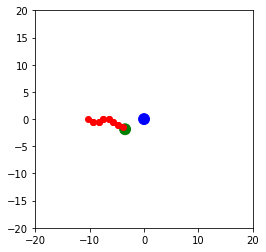

  0%|▏                                                                        | 1000/500000 [00:52<12:11:10, 11.37it/s]

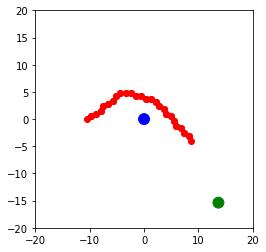

  0%|▎                                                                         | 1999/500000 [02:13<8:39:54, 15.96it/s]

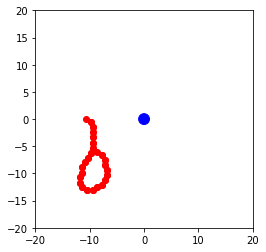

  1%|▍                                                                        | 2999/500000 [03:33<11:49:03, 11.68it/s]

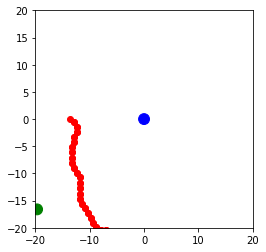

  1%|▌                                                                         | 4000/500000 [04:51<8:49:15, 15.62it/s]

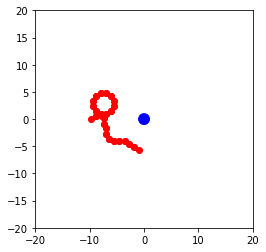

  1%|▋                                                                         | 4999/500000 [05:45<6:19:31, 21.74it/s]

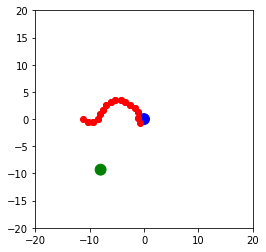

  1%|▉                                                                         | 5998/500000 [06:30<5:58:54, 22.94it/s]

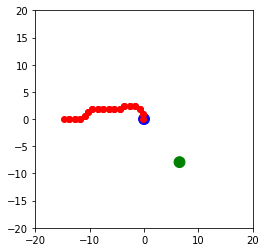

  1%|█                                                                         | 7000/500000 [07:18<6:24:18, 21.38it/s]

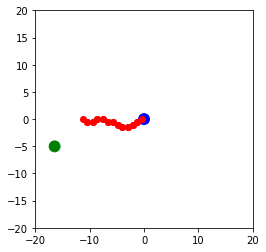

  2%|█▏                                                                        | 8000/500000 [08:04<6:13:54, 21.93it/s]

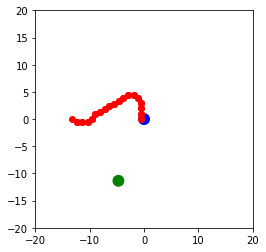

  2%|█▎                                                                        | 8999/500000 [08:51<7:04:38, 19.27it/s]

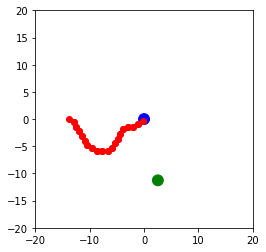

  2%|█▍                                                                        | 9998/500000 [09:40<6:25:12, 21.20it/s]

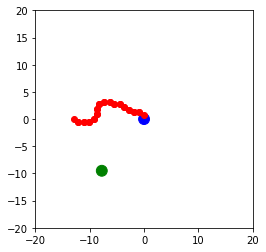

  2%|█▌                                                                       | 10999/500000 [10:27<6:45:29, 20.10it/s]

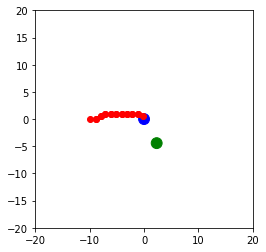

  2%|█▊                                                                       | 11998/500000 [11:13<5:35:58, 24.21it/s]

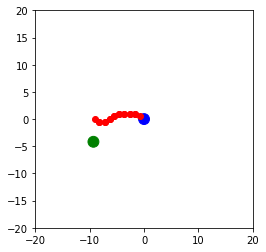

  3%|█▉                                                                       | 12999/500000 [11:59<6:39:40, 20.31it/s]

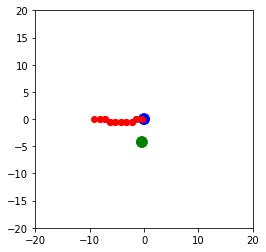

  3%|██                                                                       | 13999/500000 [12:44<6:46:45, 19.91it/s]

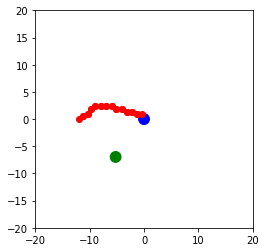

  3%|██▏                                                                      | 14999/500000 [13:30<6:22:00, 21.16it/s]

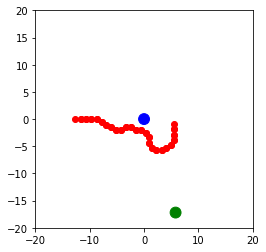

  3%|██▎                                                                      | 15998/500000 [14:17<6:21:12, 21.16it/s]

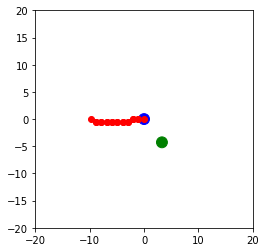

  3%|██▍                                                                      | 16999/500000 [15:01<5:53:30, 22.77it/s]

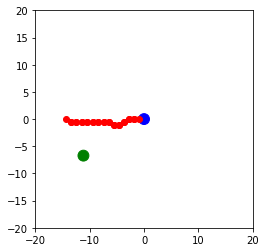

  4%|██▋                                                                      | 18000/500000 [15:47<6:35:37, 20.31it/s]

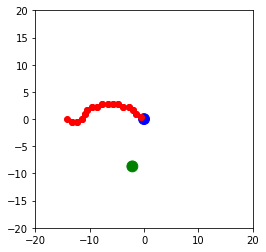

  4%|██▊                                                                      | 19000/500000 [16:30<5:36:50, 23.80it/s]

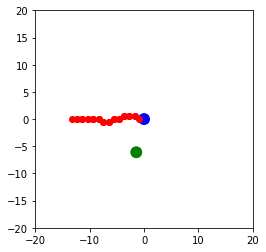

  4%|██▉                                                                      | 19998/500000 [17:17<6:51:10, 19.46it/s]

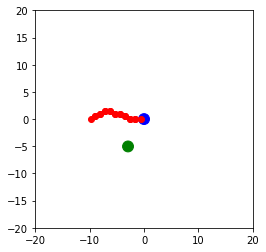

  4%|███                                                                      | 21000/500000 [18:02<6:00:46, 22.13it/s]

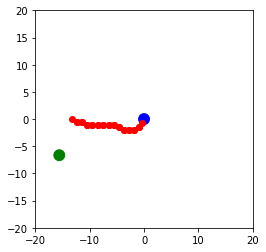

  4%|███▏                                                                     | 22000/500000 [18:47<6:22:49, 20.81it/s]

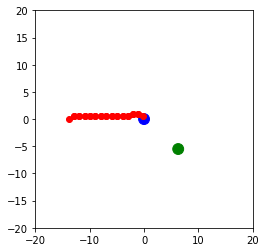

  5%|███▎                                                                     | 22998/500000 [19:34<6:04:13, 21.83it/s]

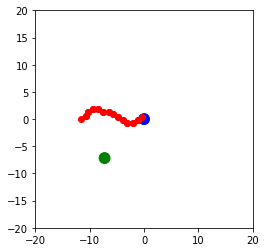

  5%|███▌                                                                     | 24000/500000 [20:19<5:48:43, 22.75it/s]

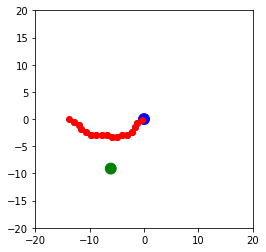

  5%|███▋                                                                     | 25000/500000 [21:04<5:52:17, 22.47it/s]

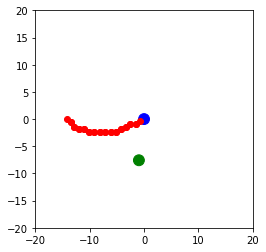

  5%|███▊                                                                     | 25999/500000 [21:48<5:45:53, 22.84it/s]

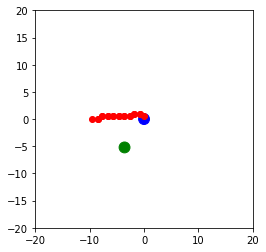

  5%|███▉                                                                     | 26999/500000 [22:32<5:37:49, 23.34it/s]

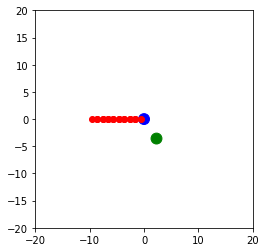

  6%|████                                                                     | 27999/500000 [23:15<5:49:06, 22.53it/s]

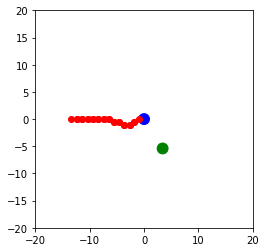

  6%|████▏                                                                    | 28999/500000 [23:59<5:22:28, 24.34it/s]

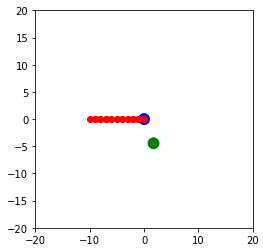

  6%|████▍                                                                    | 30000/500000 [24:43<5:56:46, 21.96it/s]

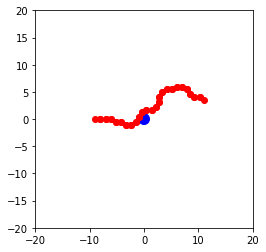

  6%|████▌                                                                    | 30998/500000 [25:30<5:11:45, 25.07it/s]

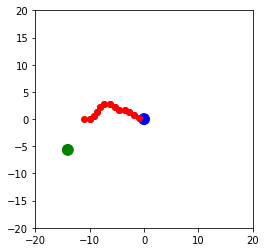

  6%|████▋                                                                    | 31998/500000 [26:16<5:25:04, 23.99it/s]

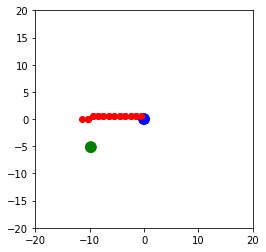

  7%|████▊                                                                    | 32999/500000 [27:02<5:51:25, 22.15it/s]

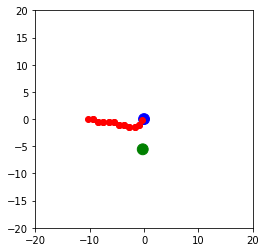

  7%|████▉                                                                    | 33999/500000 [27:50<6:25:21, 20.15it/s]

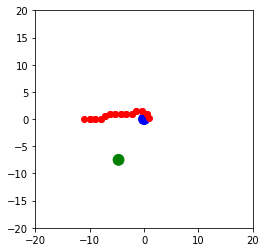

  7%|█████                                                                    | 35000/500000 [28:37<5:39:53, 22.80it/s]

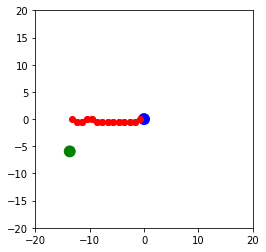

  7%|█████▎                                                                   | 36000/500000 [29:23<5:05:41, 25.30it/s]

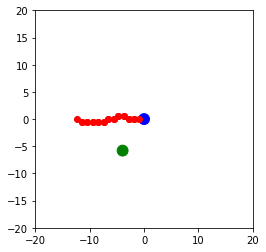

  7%|█████▍                                                                   | 36998/500000 [30:09<5:50:53, 21.99it/s]

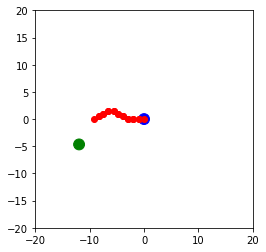

  8%|█████▌                                                                   | 37998/500000 [30:55<6:33:33, 19.57it/s]

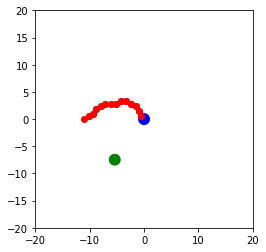

  8%|█████▋                                                                   | 39000/500000 [31:43<5:33:13, 23.06it/s]

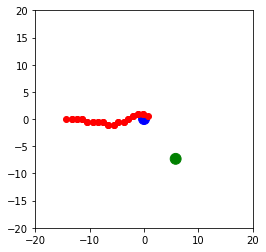

  8%|█████▊                                                                   | 39998/500000 [32:32<6:05:38, 20.97it/s]

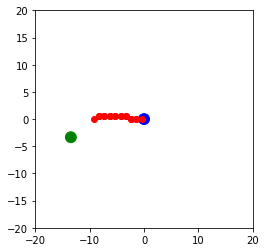

  8%|█████▉                                                                   | 40997/500000 [33:16<5:36:16, 22.75it/s]

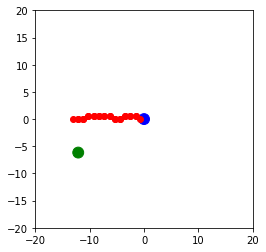

  8%|██████▏                                                                  | 42000/500000 [34:01<6:45:02, 18.85it/s]

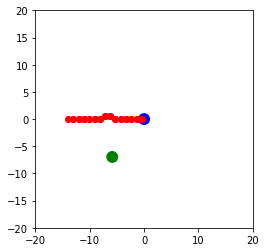

  9%|██████▎                                                                  | 42998/500000 [34:49<5:15:20, 24.15it/s]

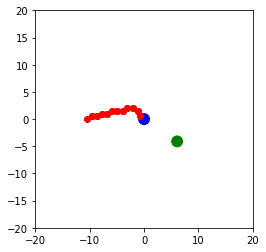

  9%|██████▍                                                                  | 44000/500000 [35:34<5:54:55, 21.41it/s]

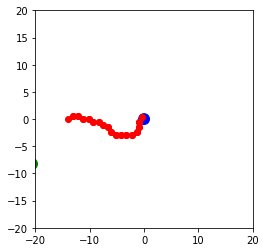

  9%|██████▌                                                                  | 45000/500000 [36:18<5:00:48, 25.21it/s]

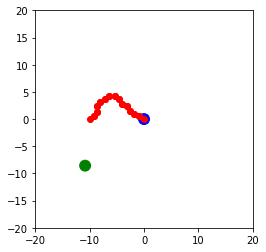

  9%|██████▋                                                                  | 45999/500000 [37:03<4:42:18, 26.80it/s]

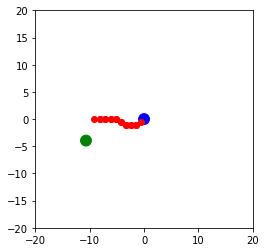

  9%|██████▊                                                                  | 46999/500000 [37:48<5:27:39, 23.04it/s]

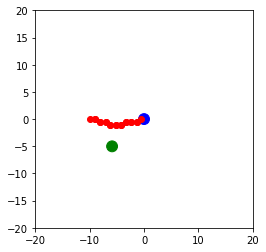

 10%|███████                                                                  | 47998/500000 [38:33<5:52:19, 21.38it/s]

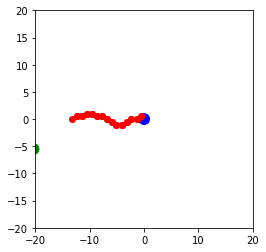

 10%|███████▏                                                                 | 49000/500000 [39:18<5:22:17, 23.32it/s]

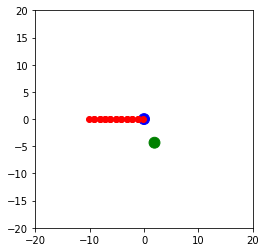

 10%|███████▎                                                                 | 49999/500000 [40:04<7:36:24, 16.43it/s]

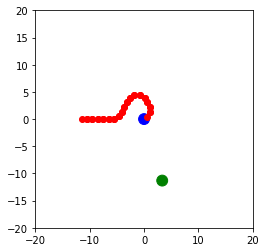

 10%|███████▍                                                                 | 51000/500000 [40:48<5:24:53, 23.03it/s]

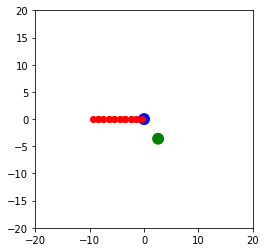

 10%|███████▌                                                                 | 52000/500000 [41:31<5:22:40, 23.14it/s]

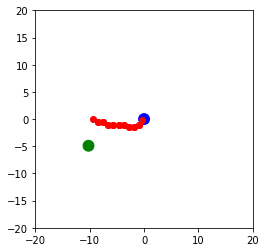

 11%|███████▋                                                                 | 53000/500000 [42:15<4:41:18, 26.48it/s]

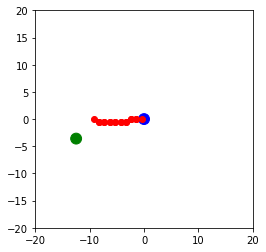

 11%|███████▉                                                                 | 53999/500000 [42:58<5:01:39, 24.64it/s]

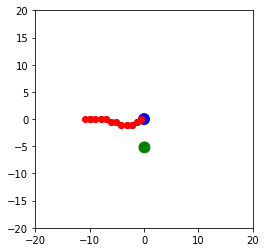

 11%|████████                                                                 | 54998/500000 [43:42<5:16:58, 23.40it/s]

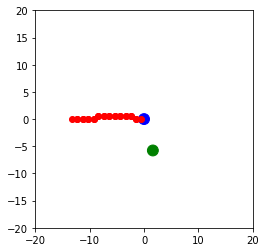

 11%|████████▏                                                                | 55998/500000 [44:26<5:34:41, 22.11it/s]

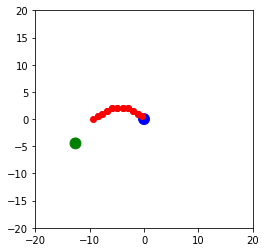

 11%|████████▎                                                                | 56998/500000 [45:11<5:22:54, 22.87it/s]

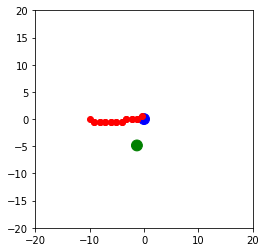

 12%|████████▍                                                                | 57999/500000 [45:56<6:18:19, 19.47it/s]

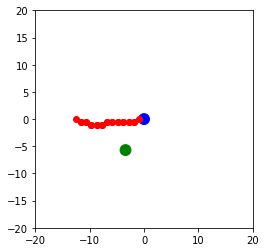

 12%|████████▌                                                                | 59000/500000 [46:42<6:00:39, 20.38it/s]

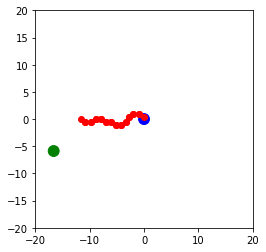

 12%|████████▊                                                                | 59999/500000 [47:28<5:03:31, 24.16it/s]

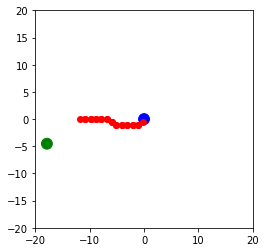

 12%|████████▉                                                                | 60999/500000 [48:13<5:10:41, 23.55it/s]

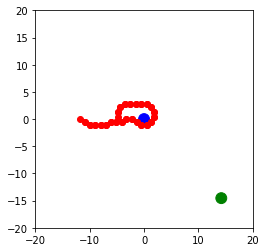

 12%|█████████                                                                | 62000/500000 [48:58<5:07:56, 23.71it/s]

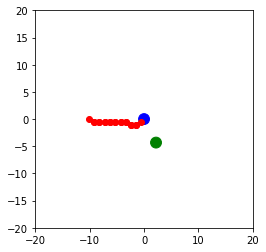

 13%|█████████▏                                                               | 62999/500000 [49:42<6:38:38, 18.27it/s]

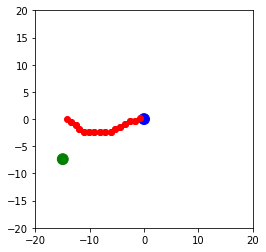

 13%|█████████▎                                                               | 63999/500000 [50:27<5:42:59, 21.19it/s]

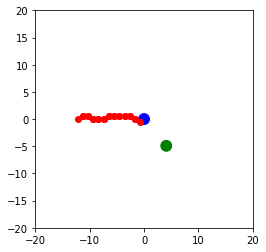

 13%|█████████▍                                                               | 64998/500000 [51:12<5:41:07, 21.25it/s]

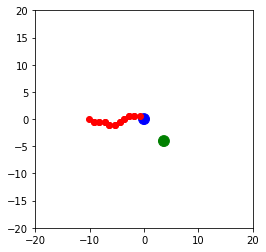

 13%|█████████▋                                                               | 66000/500000 [51:57<5:52:47, 20.50it/s]

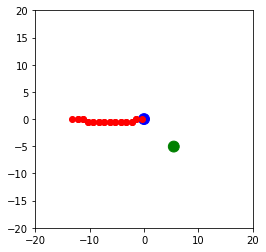

 13%|█████████▊                                                               | 66998/500000 [52:42<5:15:50, 22.85it/s]

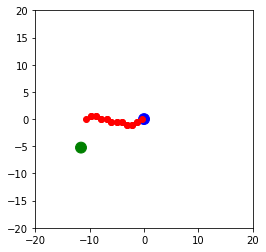

 14%|█████████▉                                                               | 67999/500000 [53:28<5:42:05, 21.05it/s]

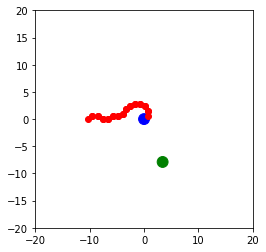

 14%|██████████                                                               | 68997/500000 [54:13<4:56:12, 24.25it/s]

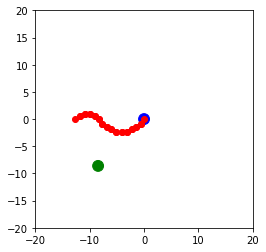

 14%|██████████▏                                                              | 69998/500000 [54:57<5:41:22, 20.99it/s]

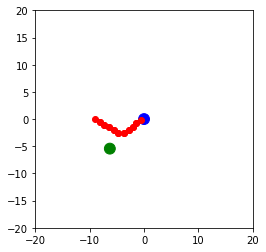

 14%|██████████▎                                                              | 71000/500000 [55:41<5:03:02, 23.59it/s]

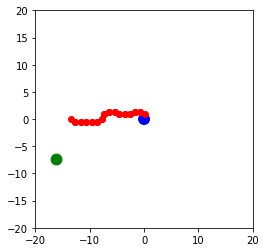

 14%|██████████▌                                                              | 71998/500000 [56:27<5:41:57, 20.86it/s]

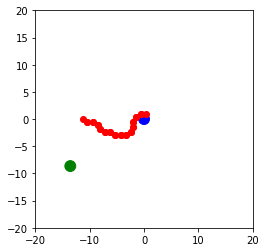

 15%|██████████▋                                                              | 72999/500000 [57:13<4:46:18, 24.86it/s]

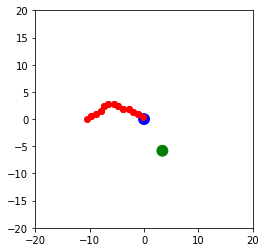

 15%|██████████▊                                                              | 73997/500000 [57:57<5:51:34, 20.20it/s]

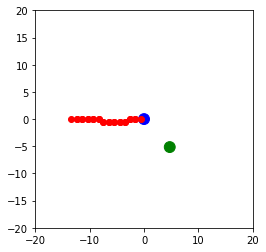

 15%|██████████▉                                                              | 74999/500000 [58:41<5:23:12, 21.92it/s]

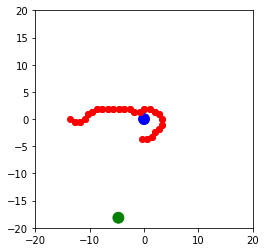

 15%|███████████                                                              | 75999/500000 [59:26<5:00:47, 23.49it/s]

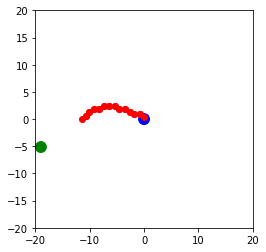

 15%|██████████▉                                                            | 76998/500000 [1:00:10<5:22:42, 21.85it/s]

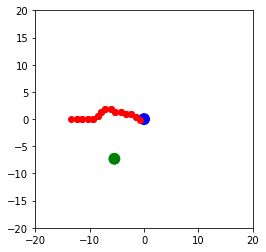

 16%|███████████                                                            | 77997/500000 [1:00:56<4:58:13, 23.58it/s]

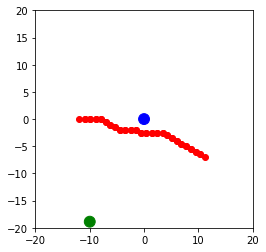

 16%|███████████▏                                                           | 78998/500000 [1:01:41<5:28:12, 21.38it/s]

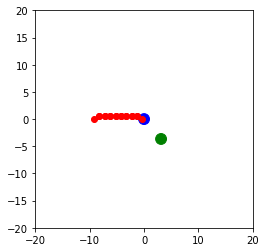

 16%|███████████▎                                                           | 80000/500000 [1:02:27<5:28:19, 21.32it/s]

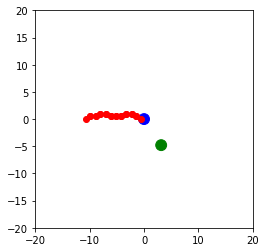

 16%|███████████▌                                                           | 81000/500000 [1:03:14<5:02:35, 23.08it/s]

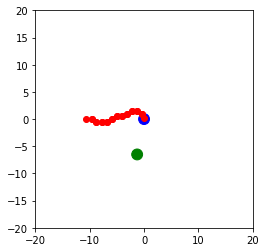

 16%|███████████▋                                                           | 81998/500000 [1:04:00<5:51:24, 19.83it/s]

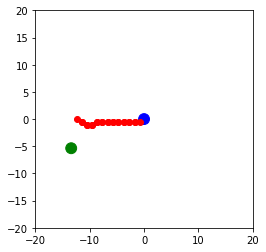

 17%|███████████▊                                                           | 82999/500000 [1:04:47<5:12:58, 22.21it/s]

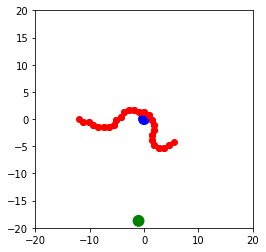

 17%|███████████▉                                                           | 84000/500000 [1:05:35<5:42:44, 20.23it/s]

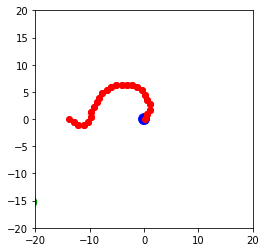

 17%|████████████                                                           | 84998/500000 [1:06:23<4:41:53, 24.54it/s]

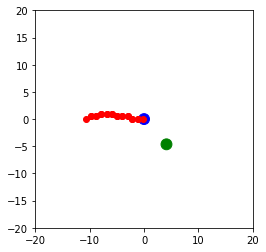

 17%|████████████▏                                                          | 85998/500000 [1:07:11<5:13:54, 21.98it/s]

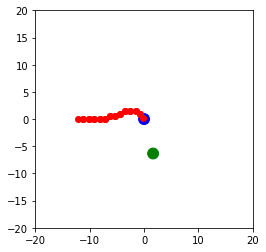

 17%|████████████▎                                                          | 86999/500000 [1:08:04<6:40:02, 17.21it/s]

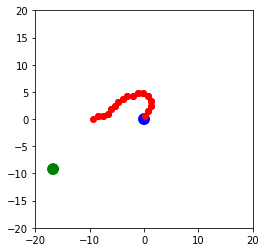

 18%|████████████▍                                                          | 87999/500000 [1:08:50<5:19:43, 21.48it/s]

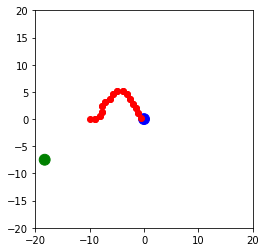

 18%|████████████▋                                                          | 89000/500000 [1:09:37<4:39:40, 24.49it/s]

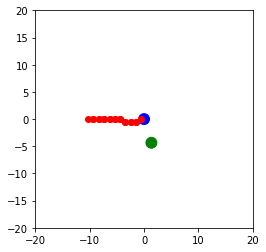

 18%|████████████▊                                                          | 89999/500000 [1:10:25<4:54:14, 23.22it/s]

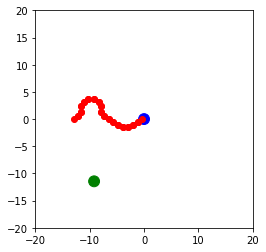

 18%|████████████▉                                                          | 90998/500000 [1:11:10<5:41:17, 19.97it/s]

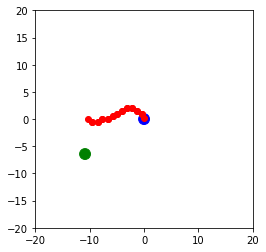

 18%|█████████████                                                          | 91998/500000 [1:11:57<4:58:40, 22.77it/s]

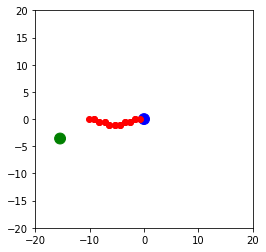

 19%|█████████████▏                                                         | 92999/500000 [1:12:45<4:49:49, 23.40it/s]

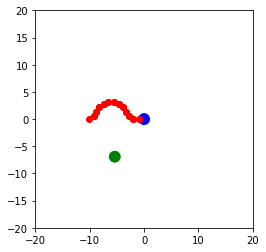

 19%|█████████████▎                                                         | 94000/500000 [1:13:30<4:26:45, 25.37it/s]

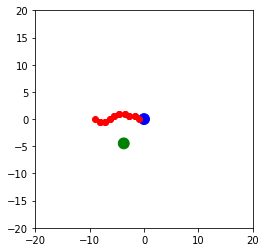

 19%|█████████████▍                                                         | 94998/500000 [1:14:15<4:57:12, 22.71it/s]

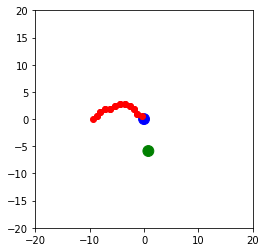

 19%|█████████████▋                                                         | 96000/500000 [1:14:59<5:22:09, 20.90it/s]

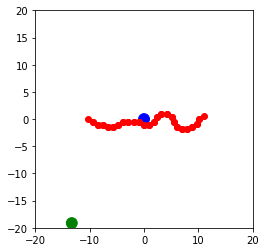

 19%|█████████████▊                                                         | 97000/500000 [1:15:43<4:35:54, 24.34it/s]

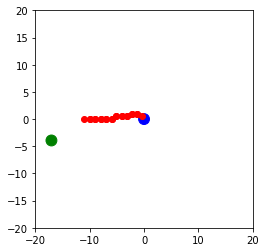

 20%|█████████████▉                                                         | 97999/500000 [1:16:25<4:41:40, 23.79it/s]

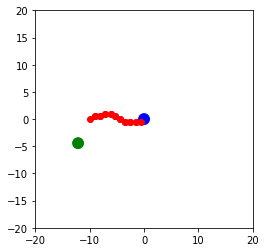

 20%|██████████████                                                         | 98999/500000 [1:17:09<4:20:35, 25.65it/s]

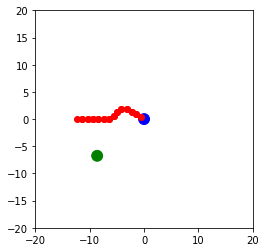

 20%|██████████████▏                                                        | 99999/500000 [1:17:53<4:36:36, 24.10it/s]

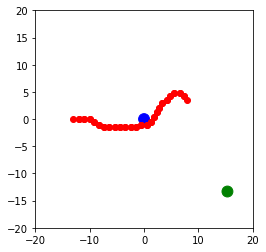

 20%|██████████████▏                                                       | 100998/500000 [1:18:35<4:51:22, 22.82it/s]

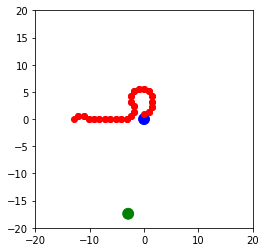

 20%|██████████████▎                                                       | 101998/500000 [1:19:17<5:11:54, 21.27it/s]

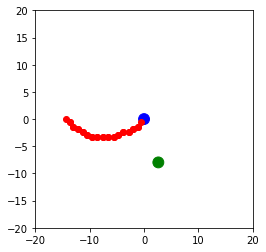

 21%|██████████████▍                                                       | 102998/500000 [1:20:02<4:15:57, 25.85it/s]

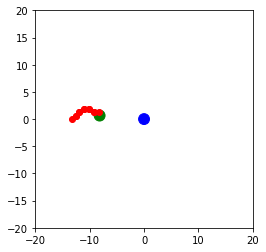

 21%|██████████████▌                                                       | 104000/500000 [1:20:46<4:21:25, 25.25it/s]

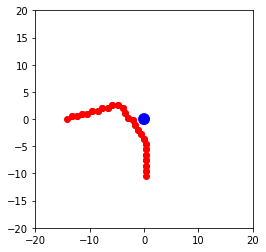

 21%|██████████████▋                                                       | 104998/500000 [1:21:30<4:38:31, 23.64it/s]

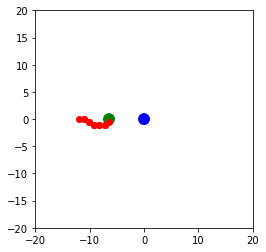

 21%|██████████████▊                                                       | 105999/500000 [1:22:12<4:16:29, 25.60it/s]

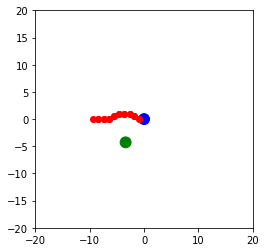

 21%|██████████████▉                                                       | 106998/500000 [1:22:56<5:34:14, 19.60it/s]

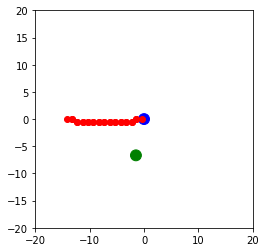

 22%|███████████████                                                       | 107999/500000 [1:23:38<4:41:52, 23.18it/s]

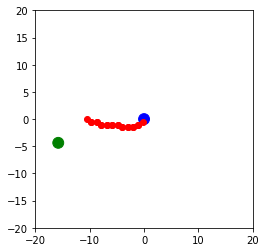

 22%|███████████████▎                                                      | 108998/500000 [1:24:22<4:30:26, 24.10it/s]

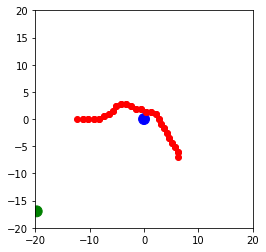

 22%|███████████████▍                                                      | 109998/500000 [1:25:05<4:51:27, 22.30it/s]

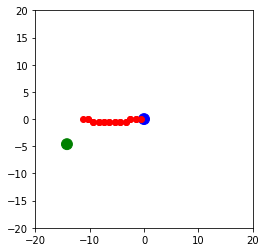

 22%|███████████████▌                                                      | 110998/500000 [1:25:50<4:55:42, 21.92it/s]

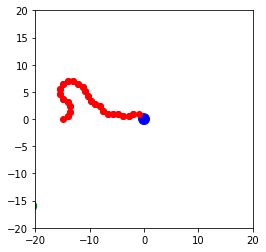

 22%|███████████████▋                                                      | 111999/500000 [1:26:35<5:11:22, 20.77it/s]

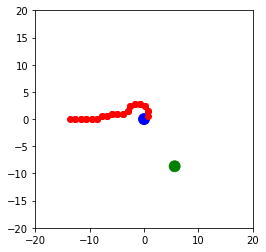

 23%|███████████████▊                                                      | 112998/500000 [1:27:20<4:34:22, 23.51it/s]

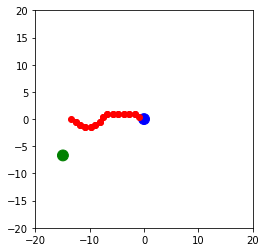

 23%|███████████████▉                                                      | 113998/500000 [1:28:04<5:48:21, 18.47it/s]

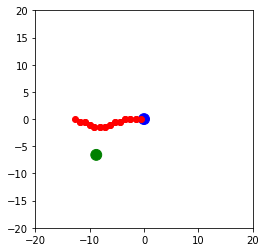

 23%|████████████████                                                      | 115000/500000 [1:28:47<4:45:53, 22.44it/s]

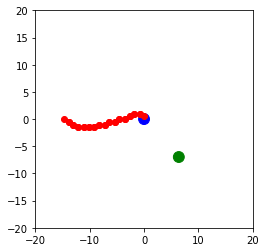

 23%|████████████████▏                                                     | 115998/500000 [1:29:30<4:37:33, 23.06it/s]

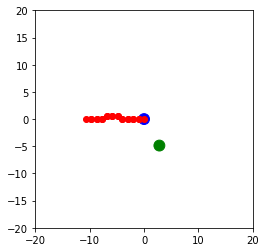

 23%|████████████████▍                                                     | 117000/500000 [1:30:15<3:59:26, 26.66it/s]

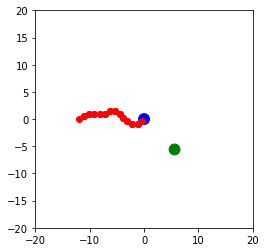

 24%|████████████████▌                                                     | 117999/500000 [1:30:57<4:07:09, 25.76it/s]

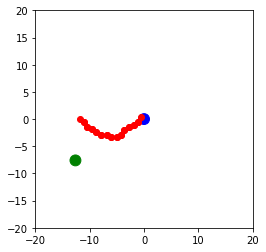

 24%|████████████████▋                                                     | 118999/500000 [1:31:38<4:16:47, 24.73it/s]

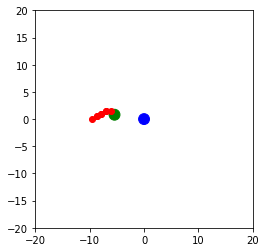

 24%|████████████████▊                                                     | 119999/500000 [1:32:20<4:17:23, 24.61it/s]

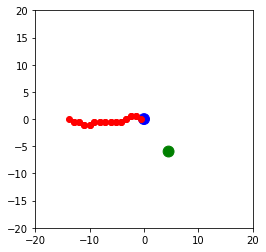

 24%|████████████████▉                                                     | 121000/500000 [1:33:01<4:54:24, 21.46it/s]

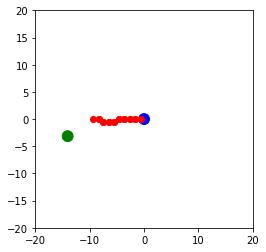

 24%|█████████████████                                                     | 121999/500000 [1:33:48<5:24:24, 19.42it/s]

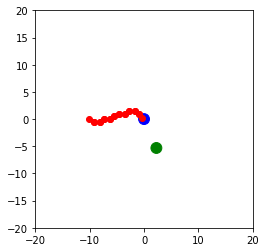

 25%|█████████████████▏                                                    | 122998/500000 [1:34:33<4:22:30, 23.94it/s]

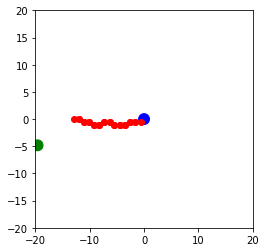

 25%|█████████████████▎                                                    | 123998/500000 [1:35:14<3:59:30, 26.17it/s]

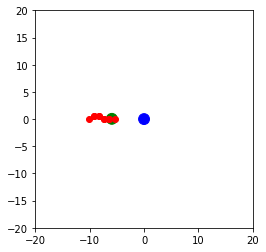

 25%|█████████████████▍                                                    | 124998/500000 [1:35:55<3:44:25, 27.85it/s]

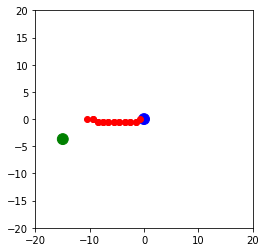

 25%|█████████████████▋                                                    | 125998/500000 [1:36:38<4:19:34, 24.01it/s]

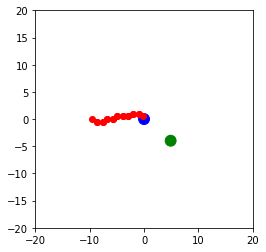

 25%|█████████████████▊                                                    | 126999/500000 [1:37:22<4:10:01, 24.86it/s]

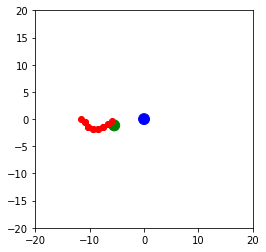

 26%|█████████████████▉                                                    | 127999/500000 [1:38:06<4:17:58, 24.03it/s]

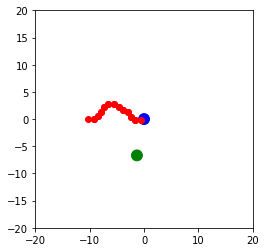

 26%|██████████████████                                                    | 128999/500000 [1:38:47<3:53:36, 26.47it/s]

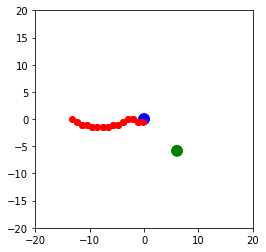

 26%|██████████████████▏                                                   | 129998/500000 [1:39:29<4:19:56, 23.72it/s]

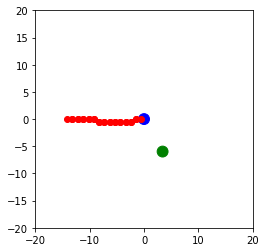

 26%|██████████████████▎                                                   | 130998/500000 [1:40:14<4:18:44, 23.77it/s]

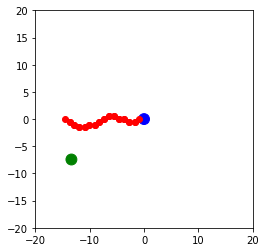

 26%|██████████████████▍                                                   | 131999/500000 [1:40:59<5:45:36, 17.75it/s]

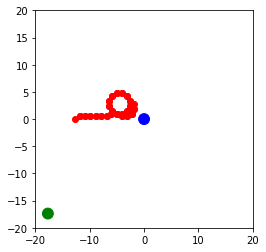

 27%|██████████████████▌                                                   | 133000/500000 [1:41:45<4:54:20, 20.78it/s]

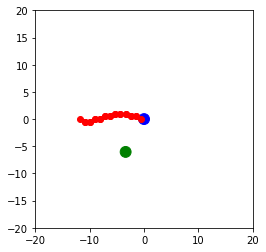

 27%|██████████████████▊                                                   | 134000/500000 [1:42:29<4:37:42, 21.97it/s]

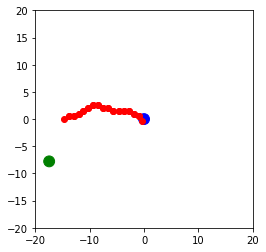

 27%|██████████████████▉                                                   | 135000/500000 [1:43:14<4:31:55, 22.37it/s]

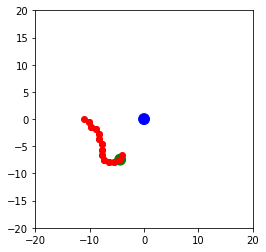

 27%|███████████████████                                                   | 135998/500000 [1:44:01<4:05:02, 24.76it/s]

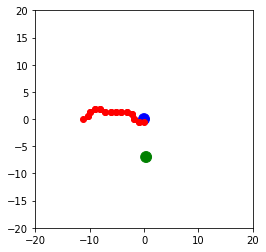

 27%|███████████████████▏                                                  | 136998/500000 [1:44:45<4:25:24, 22.80it/s]

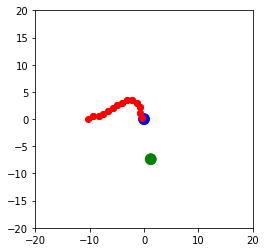

 28%|███████████████████▎                                                  | 138000/500000 [1:45:31<4:26:33, 22.63it/s]

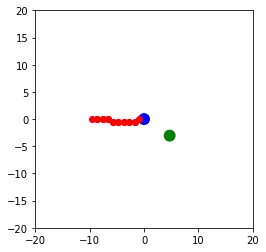

 28%|███████████████████▍                                                  | 138999/500000 [1:46:16<6:12:53, 16.14it/s]

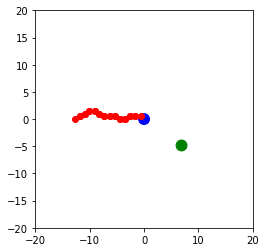

 28%|███████████████████▌                                                  | 139998/500000 [1:47:03<5:03:15, 19.79it/s]

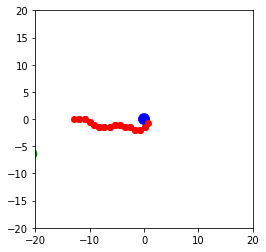

 28%|███████████████████▋                                                  | 140999/500000 [1:47:47<4:29:04, 22.24it/s]

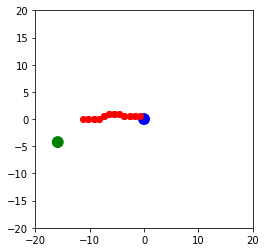

 28%|███████████████████▉                                                  | 141999/500000 [1:48:33<4:36:37, 21.57it/s]

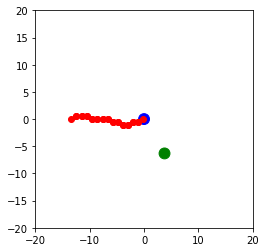

 29%|████████████████████                                                  | 142999/500000 [1:49:17<4:21:57, 22.71it/s]

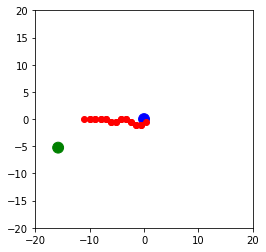

 29%|████████████████████▏                                                 | 143999/500000 [1:50:03<4:02:05, 24.51it/s]

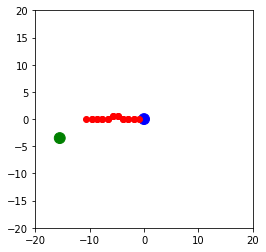

 29%|████████████████████▎                                                 | 145000/500000 [1:50:47<4:16:34, 23.06it/s]

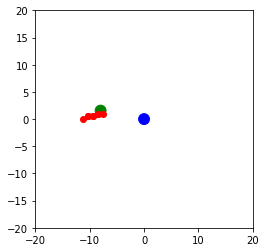

 29%|████████████████████▍                                                 | 146000/500000 [1:51:34<4:49:27, 20.38it/s]

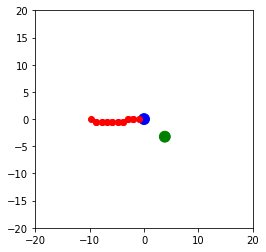

 29%|████████████████████▌                                                 | 146998/500000 [1:52:21<5:36:35, 17.48it/s]

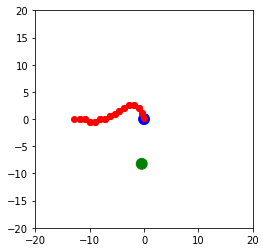

 30%|████████████████████▋                                                 | 147998/500000 [1:53:06<4:06:29, 23.80it/s]

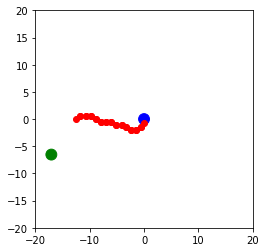

 30%|████████████████████▊                                                 | 149000/500000 [1:53:49<4:15:30, 22.89it/s]

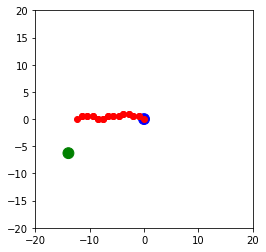

 30%|████████████████████▉                                                 | 149998/500000 [1:54:35<4:37:22, 21.03it/s]

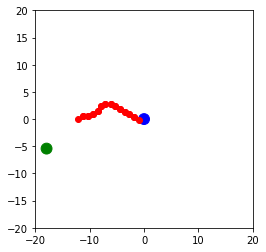

 30%|█████████████████████▏                                                | 151000/500000 [1:55:19<3:45:06, 25.84it/s]

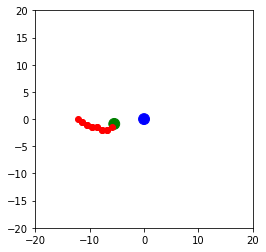

 30%|█████████████████████▎                                                | 152000/500000 [1:56:02<3:54:06, 24.78it/s]

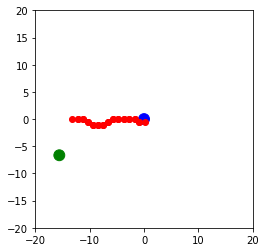

 31%|█████████████████████▍                                                | 152999/500000 [1:56:46<4:35:14, 21.01it/s]

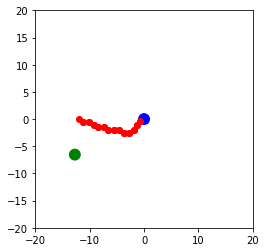

 31%|█████████████████████▌                                                | 154000/500000 [1:57:31<3:57:37, 24.27it/s]

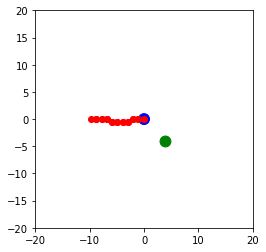

 31%|█████████████████████▋                                                | 154998/500000 [1:58:15<3:47:56, 25.23it/s]

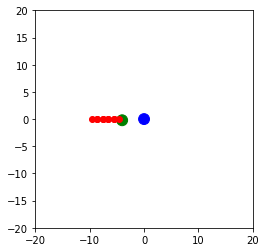

 31%|█████████████████████▊                                                | 155998/500000 [1:58:59<3:50:48, 24.84it/s]

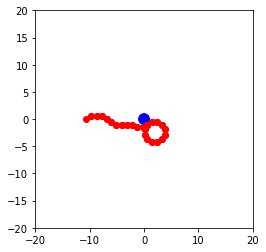

 31%|█████████████████████▉                                                | 157000/500000 [1:59:45<4:18:47, 22.09it/s]

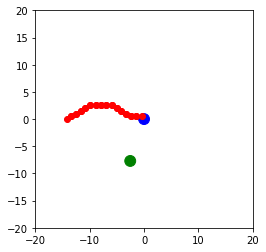

 32%|██████████████████████                                                | 158000/500000 [2:00:28<4:06:22, 23.14it/s]

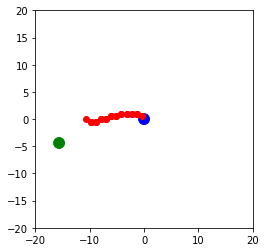

 32%|██████████████████████▎                                               | 158998/500000 [2:01:13<4:01:39, 23.52it/s]

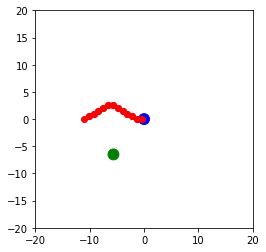

 32%|██████████████████████▍                                               | 159999/500000 [2:02:00<4:03:31, 23.27it/s]

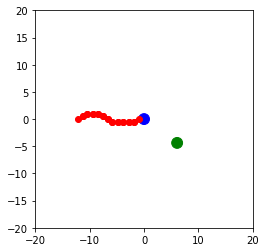

 32%|██████████████████████▌                                               | 160998/500000 [2:02:45<4:29:18, 20.98it/s]

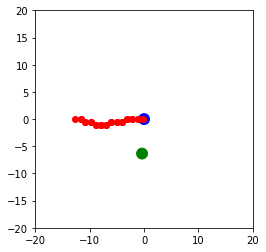

 32%|██████████████████████▋                                               | 161998/500000 [2:03:33<4:42:28, 19.94it/s]

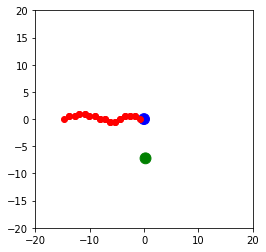

 33%|██████████████████████▊                                               | 162999/500000 [2:04:24<4:40:10, 20.05it/s]

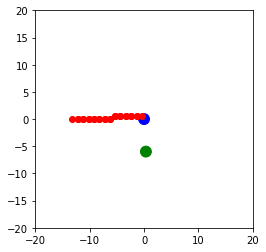

 33%|██████████████████████▉                                               | 163998/500000 [2:05:10<3:53:38, 23.97it/s]

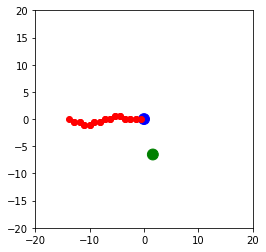

 33%|███████████████████████                                               | 165000/500000 [2:05:56<4:09:03, 22.42it/s]

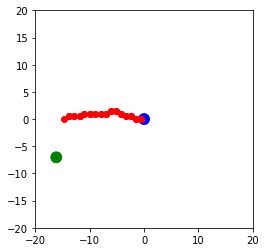

 33%|███████████████████████▏                                              | 165999/500000 [2:06:40<4:48:39, 19.28it/s]

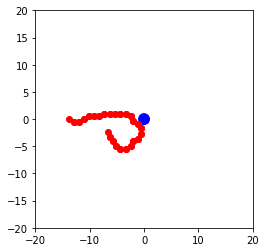

 33%|███████████████████████▍                                              | 167000/500000 [2:07:25<4:01:22, 22.99it/s]

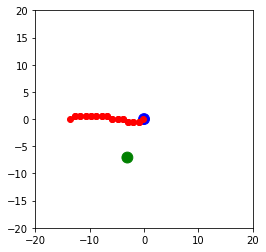

 34%|███████████████████████▌                                              | 167999/500000 [2:08:09<3:56:20, 23.41it/s]

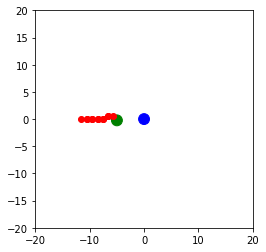

 34%|███████████████████████▋                                              | 169000/500000 [2:08:54<3:51:21, 23.84it/s]

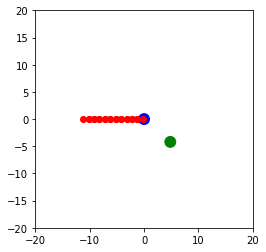

 34%|███████████████████████▊                                              | 169998/500000 [2:09:39<3:51:39, 23.74it/s]

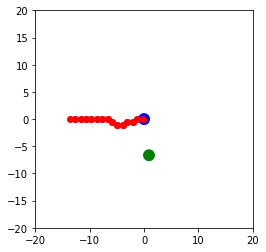

 34%|███████████████████████▉                                              | 171000/500000 [2:10:24<3:44:45, 24.40it/s]

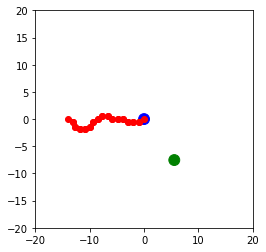

 34%|████████████████████████                                              | 172000/500000 [2:11:10<3:44:49, 24.32it/s]

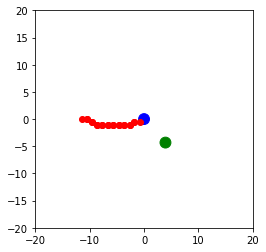

 35%|████████████████████████▏                                             | 173000/500000 [2:11:54<4:47:14, 18.97it/s]

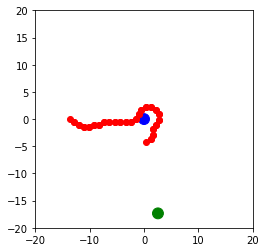

 35%|████████████████████████▎                                             | 174000/500000 [2:12:39<3:54:40, 23.15it/s]

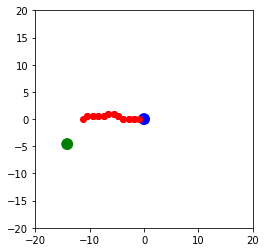

 35%|████████████████████████▍                                             | 174998/500000 [2:13:25<4:39:34, 19.37it/s]

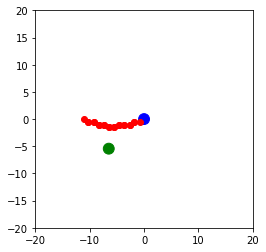

 35%|████████████████████████▋                                             | 175999/500000 [2:14:11<3:37:15, 24.85it/s]

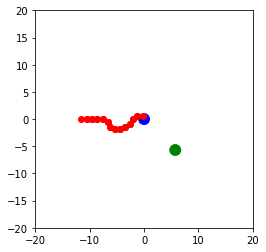

 35%|████████████████████████▊                                             | 176999/500000 [2:14:56<3:52:00, 23.20it/s]

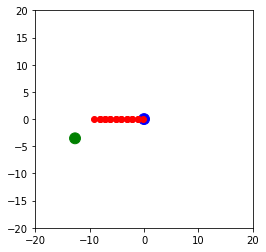

 36%|████████████████████████▉                                             | 177999/500000 [2:15:42<3:58:25, 22.51it/s]

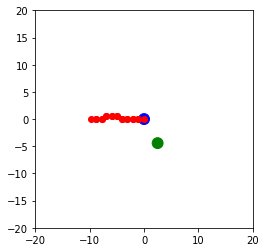

 36%|█████████████████████████                                             | 178998/500000 [2:16:30<4:08:29, 21.53it/s]

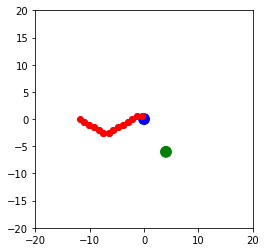

 36%|█████████████████████████▏                                            | 179998/500000 [2:17:17<4:01:17, 22.10it/s]

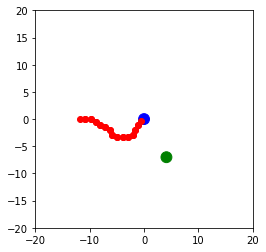

 36%|█████████████████████████▎                                            | 180998/500000 [2:18:03<3:54:25, 22.68it/s]

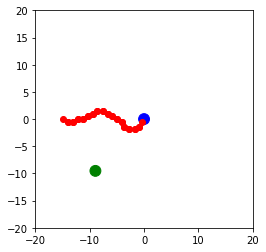

 36%|█████████████████████████▍                                            | 181998/500000 [2:18:49<3:48:29, 23.20it/s]

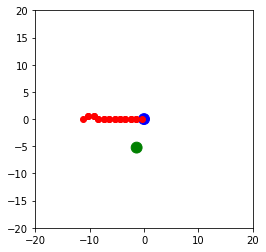

 37%|█████████████████████████▌                                            | 182999/500000 [2:19:37<4:03:03, 21.74it/s]

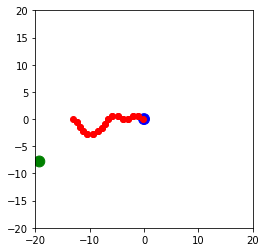

 37%|█████████████████████████▊                                            | 183999/500000 [2:20:24<4:59:18, 17.60it/s]

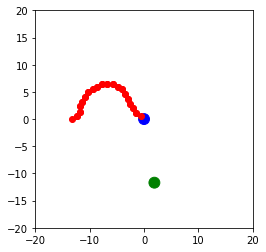

 37%|█████████████████████████▉                                            | 185000/500000 [2:21:15<3:52:37, 22.57it/s]

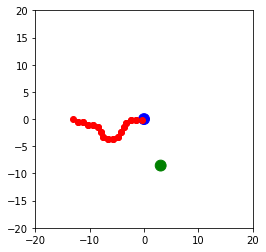

 37%|██████████████████████████                                            | 185997/500000 [2:22:01<3:56:20, 22.14it/s]

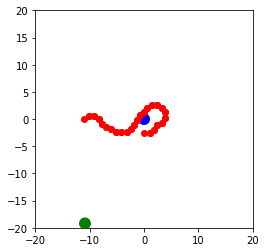

 37%|██████████████████████████▏                                           | 187000/500000 [2:22:46<3:54:45, 22.22it/s]

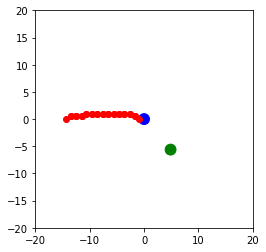

 38%|██████████████████████████▎                                           | 187998/500000 [2:23:30<3:55:13, 22.11it/s]

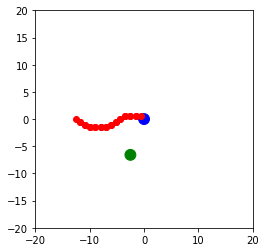

 38%|██████████████████████████▍                                           | 188998/500000 [2:24:17<4:18:36, 20.04it/s]

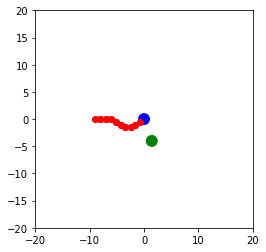

 38%|██████████████████████████▌                                           | 190000/500000 [2:25:03<3:34:43, 24.06it/s]

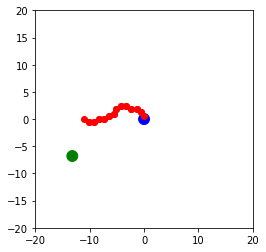

 38%|██████████████████████████▋                                           | 191000/500000 [2:25:50<4:15:12, 20.18it/s]

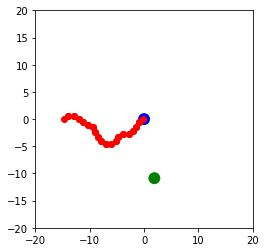

 38%|██████████████████████████▉                                           | 191998/500000 [2:26:35<3:30:19, 24.41it/s]

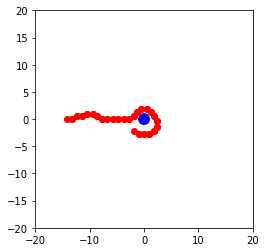

 39%|███████████████████████████                                           | 192998/500000 [2:27:20<3:29:02, 24.48it/s]

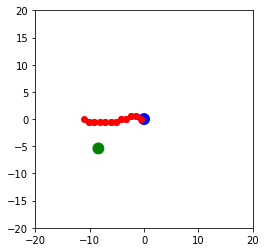

 39%|███████████████████████████▏                                          | 193999/500000 [2:28:05<4:13:04, 20.15it/s]

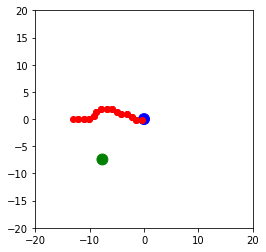

 39%|███████████████████████████▎                                          | 194998/500000 [2:28:51<4:40:39, 18.11it/s]

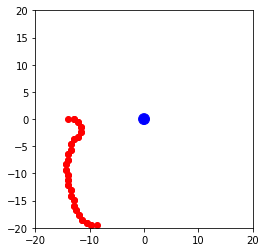

 39%|███████████████████████████▍                                          | 195999/500000 [2:29:36<3:44:18, 22.59it/s]

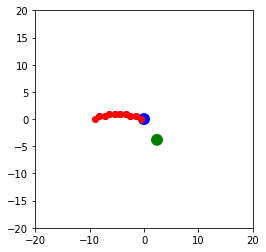

 39%|███████████████████████████▌                                          | 196998/500000 [2:30:21<4:13:43, 19.90it/s]

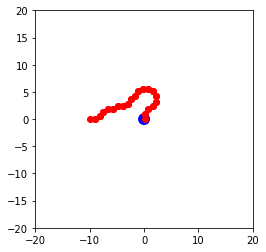

 40%|███████████████████████████▋                                          | 198000/500000 [2:31:06<4:23:22, 19.11it/s]

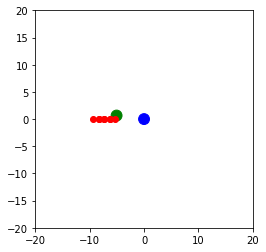

 40%|███████████████████████████▊                                          | 198998/500000 [2:31:50<3:39:28, 22.86it/s]

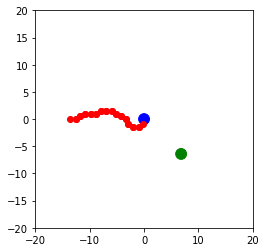

 40%|███████████████████████████▉                                          | 199999/500000 [2:32:34<4:14:46, 19.63it/s]

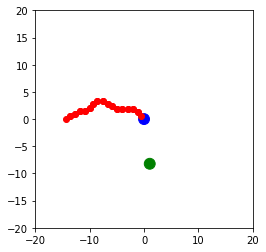

 40%|████████████████████████████▏                                         | 200999/500000 [2:33:20<4:33:32, 18.22it/s]

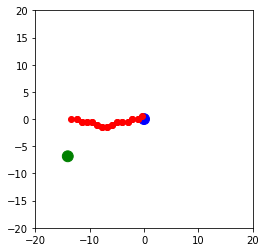

 40%|████████████████████████████▎                                         | 202000/500000 [2:34:07<3:38:50, 22.70it/s]

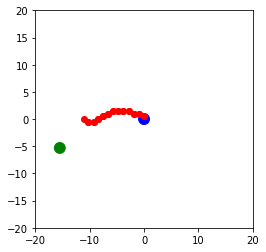

 41%|████████████████████████████▍                                         | 203000/500000 [2:34:54<3:58:49, 20.73it/s]

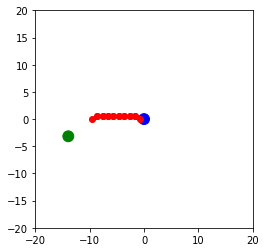

 41%|████████████████████████████▌                                         | 204000/500000 [2:35:40<3:59:51, 20.57it/s]

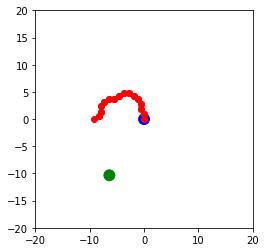

 41%|████████████████████████████▋                                         | 204999/500000 [2:36:24<3:18:49, 24.73it/s]

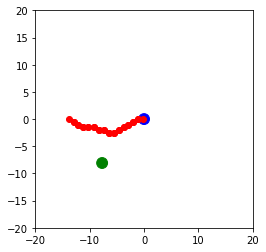

 41%|████████████████████████████▊                                         | 206000/500000 [2:37:11<3:38:18, 22.45it/s]

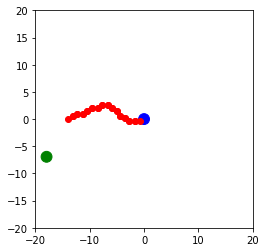

 41%|████████████████████████████▉                                         | 207000/500000 [2:37:56<3:11:29, 25.50it/s]

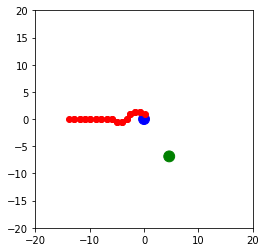

 42%|█████████████████████████████                                         | 208000/500000 [2:38:43<3:44:48, 21.65it/s]

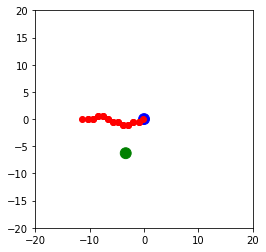

 42%|█████████████████████████████▎                                        | 208998/500000 [2:39:29<3:42:44, 21.77it/s]

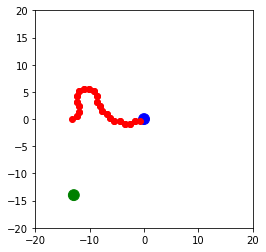

 42%|█████████████████████████████▍                                        | 209998/500000 [2:40:15<3:30:47, 22.93it/s]

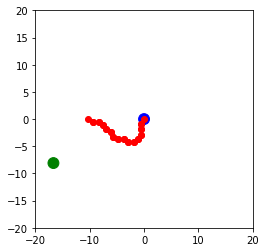

 42%|█████████████████████████████▌                                        | 210998/500000 [2:41:01<3:48:36, 21.07it/s]

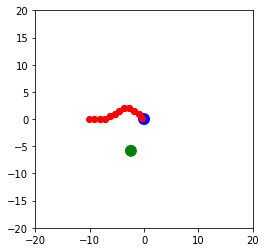

 42%|█████████████████████████████▋                                        | 212000/500000 [2:41:48<3:36:44, 22.15it/s]

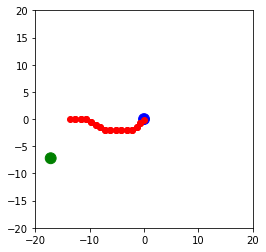

 43%|█████████████████████████████▊                                        | 212999/500000 [2:42:35<3:47:43, 21.00it/s]

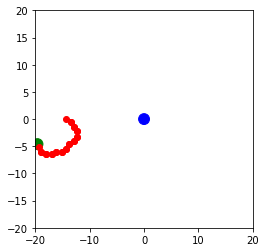

 43%|█████████████████████████████▉                                        | 214000/500000 [2:43:19<3:20:48, 23.74it/s]

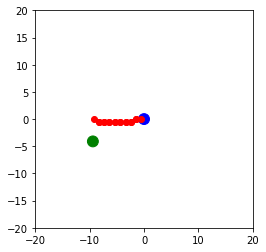

 43%|██████████████████████████████                                        | 214999/500000 [2:44:04<3:32:20, 22.37it/s]

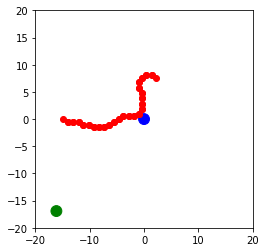

 43%|██████████████████████████████▏                                       | 216000/500000 [2:44:50<3:36:20, 21.88it/s]

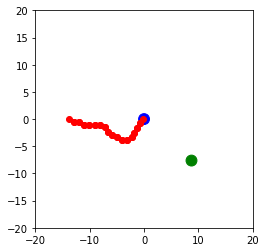

 43%|██████████████████████████████▍                                       | 216998/500000 [2:45:37<3:34:33, 21.98it/s]

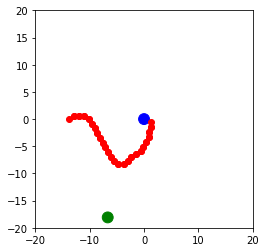

 44%|██████████████████████████████▌                                       | 217999/500000 [2:46:21<3:40:02, 21.36it/s]

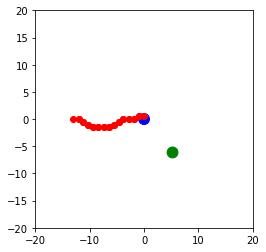

 44%|██████████████████████████████▋                                       | 218998/500000 [2:47:07<3:35:23, 21.74it/s]

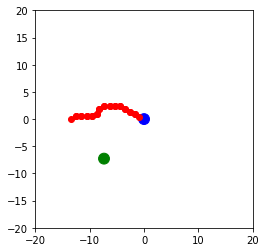

 44%|██████████████████████████████▊                                       | 220000/500000 [2:47:53<3:23:44, 22.90it/s]

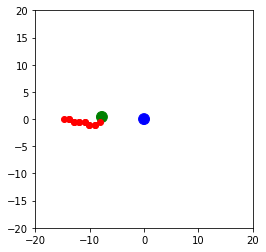

 44%|██████████████████████████████▉                                       | 221000/500000 [2:48:35<3:11:29, 24.28it/s]

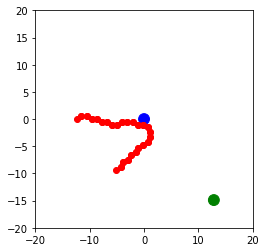

 44%|███████████████████████████████                                       | 221998/500000 [2:49:20<3:32:31, 21.80it/s]

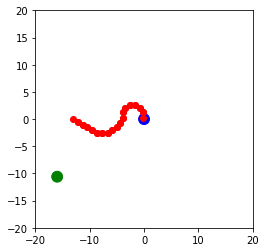

 45%|███████████████████████████████▏                                      | 222999/500000 [2:50:04<3:36:15, 21.35it/s]

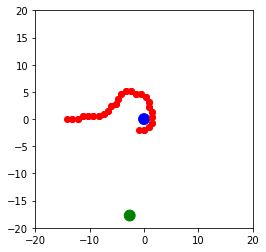

 45%|███████████████████████████████▎                                      | 224000/500000 [2:50:50<3:21:24, 22.84it/s]

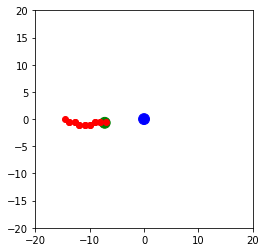

 45%|███████████████████████████████▍                                      | 224998/500000 [2:51:33<3:16:21, 23.34it/s]

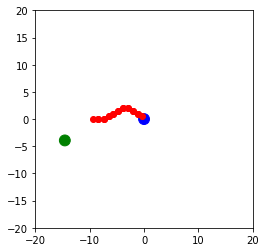

 45%|███████████████████████████████▋                                      | 225999/500000 [2:52:18<2:58:45, 25.55it/s]

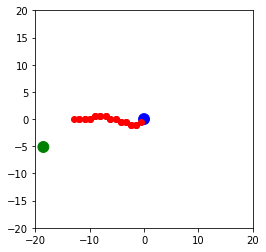

 45%|███████████████████████████████▊                                      | 226998/500000 [2:53:02<2:58:47, 25.45it/s]

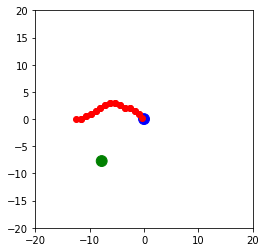

 46%|███████████████████████████████▉                                      | 228000/500000 [2:53:46<3:02:01, 24.90it/s]

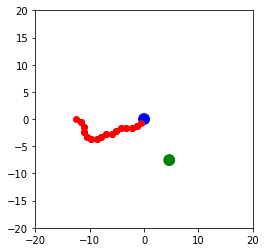

 46%|████████████████████████████████                                      | 228998/500000 [2:54:31<3:04:27, 24.49it/s]

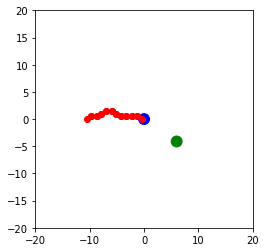

 46%|████████████████████████████████▏                                     | 229999/500000 [2:55:15<3:18:39, 22.65it/s]

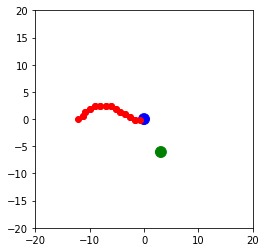

 46%|████████████████████████████████▎                                     | 230999/500000 [2:55:59<3:20:52, 22.32it/s]

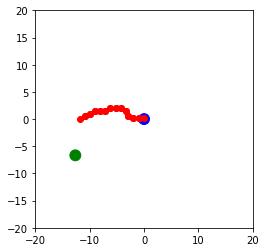

 46%|████████████████████████████████▍                                     | 231999/500000 [2:56:47<4:17:45, 17.33it/s]

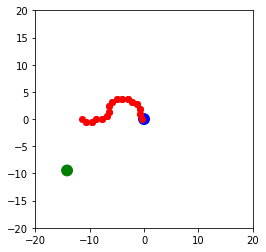

 47%|████████████████████████████████▌                                     | 233000/500000 [2:57:34<2:58:51, 24.88it/s]

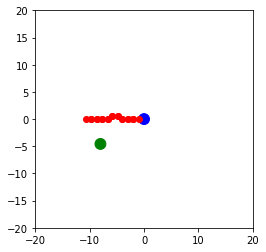

 47%|████████████████████████████████▊                                     | 233998/500000 [2:58:19<3:17:22, 22.46it/s]

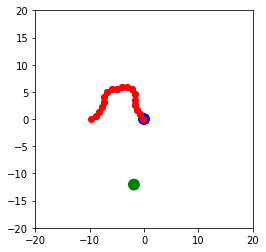

 47%|████████████████████████████████▉                                     | 234998/500000 [2:59:02<3:10:41, 23.16it/s]

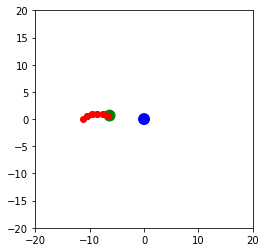

 47%|█████████████████████████████████                                     | 235998/500000 [2:59:46<3:13:18, 22.76it/s]

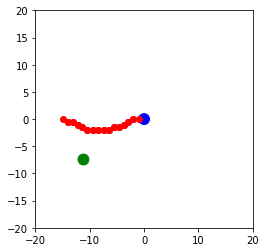

 47%|█████████████████████████████████▏                                    | 236999/500000 [3:00:32<3:29:43, 20.90it/s]

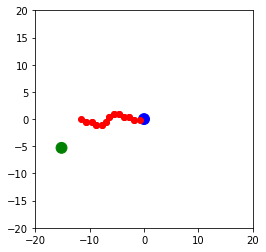

 48%|█████████████████████████████████▎                                    | 238000/500000 [3:01:19<3:25:15, 21.27it/s]

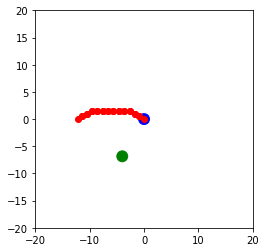

 48%|█████████████████████████████████▍                                    | 238998/500000 [3:02:05<3:33:04, 20.42it/s]

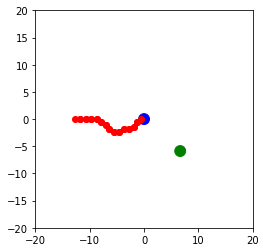

 48%|█████████████████████████████████▌                                    | 239999/500000 [3:02:52<3:12:15, 22.54it/s]

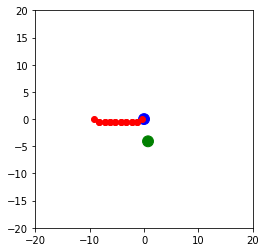

 48%|█████████████████████████████████▋                                    | 240999/500000 [3:03:38<3:05:38, 23.25it/s]

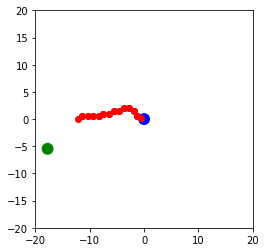

 48%|█████████████████████████████████▉                                    | 241999/500000 [3:04:22<3:11:17, 22.48it/s]

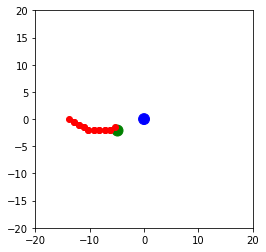

 49%|██████████████████████████████████                                    | 243000/500000 [3:05:07<3:10:51, 22.44it/s]

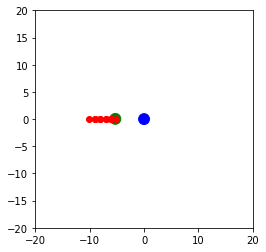

 49%|██████████████████████████████████▏                                   | 243999/500000 [3:05:52<3:33:54, 19.95it/s]

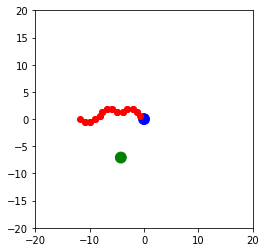

 49%|██████████████████████████████████▎                                   | 244998/500000 [3:06:38<3:36:22, 19.64it/s]

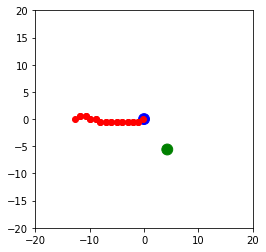

 49%|██████████████████████████████████▍                                   | 246000/500000 [3:07:28<3:19:46, 21.19it/s]

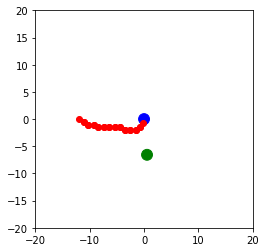

 49%|██████████████████████████████████▌                                   | 246997/500000 [3:08:15<3:33:20, 19.77it/s]

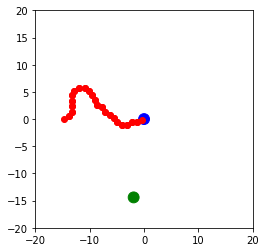

 50%|██████████████████████████████████▋                                   | 247998/500000 [3:09:01<3:08:57, 22.23it/s]

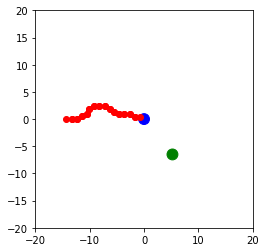

 50%|██████████████████████████████████▊                                   | 249000/500000 [3:09:48<3:10:18, 21.98it/s]

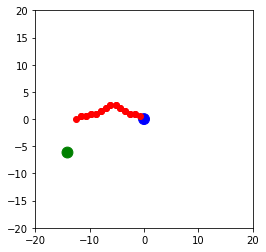

 50%|██████████████████████████████████▉                                   | 249998/500000 [3:10:35<3:09:19, 22.01it/s]

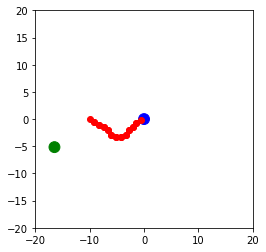

 50%|███████████████████████████████████▏                                  | 250997/500000 [3:11:19<3:17:50, 20.98it/s]

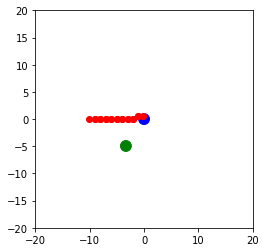

 50%|███████████████████████████████████▎                                  | 251998/500000 [3:12:05<2:38:29, 26.08it/s]

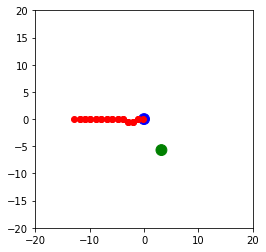

 51%|███████████████████████████████████▍                                  | 253000/500000 [3:12:49<3:26:54, 19.90it/s]

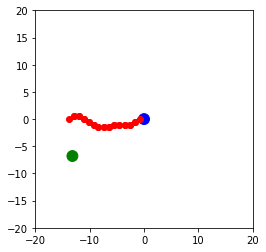

 51%|███████████████████████████████████▌                                  | 254000/500000 [3:13:33<3:01:27, 22.59it/s]

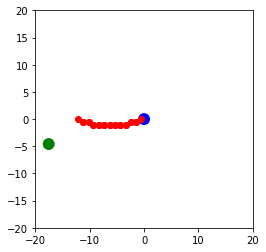

 51%|███████████████████████████████████▋                                  | 255000/500000 [3:14:19<2:32:48, 26.72it/s]

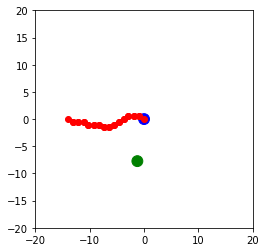

 51%|███████████████████████████████████▊                                  | 255998/500000 [3:15:06<3:18:18, 20.51it/s]

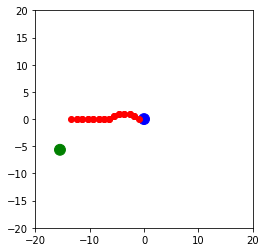

 51%|███████████████████████████████████▉                                  | 256998/500000 [3:15:50<2:53:38, 23.33it/s]

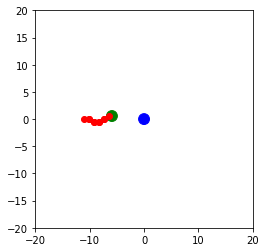

 52%|████████████████████████████████████                                  | 257998/500000 [3:16:35<3:07:50, 21.47it/s]

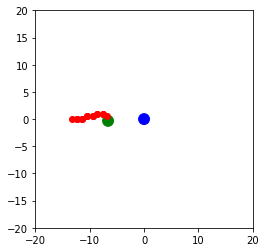

 52%|████████████████████████████████████▎                                 | 258998/500000 [3:17:23<2:59:34, 22.37it/s]

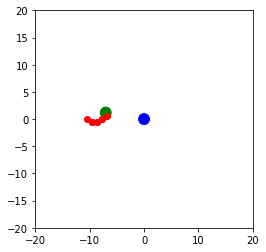

 52%|████████████████████████████████████▍                                 | 259999/500000 [3:18:09<3:19:32, 20.05it/s]

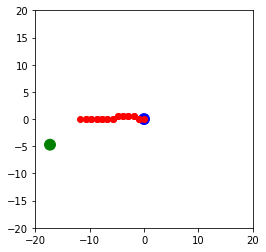

 52%|████████████████████████████████████▌                                 | 261000/500000 [3:18:54<2:52:41, 23.07it/s]

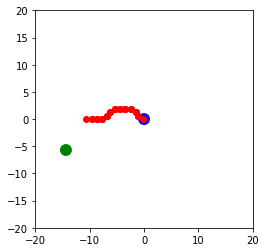

 52%|████████████████████████████████████▋                                 | 261999/500000 [3:19:40<3:10:53, 20.78it/s]

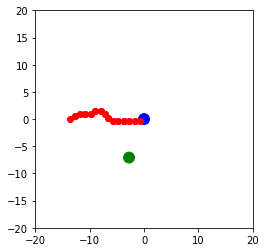

 53%|████████████████████████████████████▊                                 | 262999/500000 [3:20:24<2:37:13, 25.12it/s]

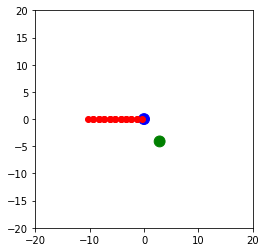

 53%|████████████████████████████████████▉                                 | 264000/500000 [3:21:10<3:03:19, 21.46it/s]

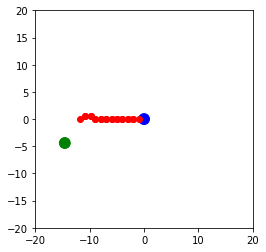

 53%|█████████████████████████████████████                                 | 264999/500000 [3:21:54<3:03:26, 21.35it/s]

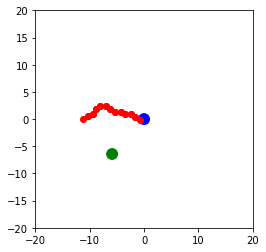

 53%|█████████████████████████████████████▏                                | 266000/500000 [3:22:39<2:51:38, 22.72it/s]

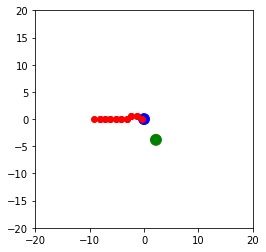

 53%|█████████████████████████████████████▍                                | 266998/500000 [3:23:24<2:32:54, 25.40it/s]

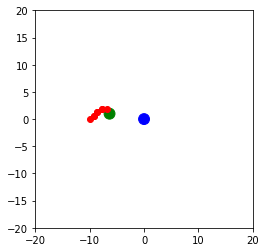

 54%|█████████████████████████████████████▌                                | 267999/500000 [3:24:10<2:40:20, 24.11it/s]

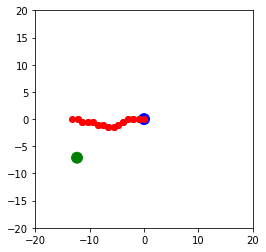

 54%|█████████████████████████████████████▋                                | 269000/500000 [3:24:55<2:36:46, 24.56it/s]

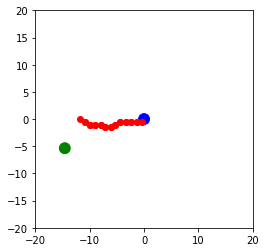

 54%|█████████████████████████████████████▊                                | 270000/500000 [3:25:40<2:52:11, 22.26it/s]

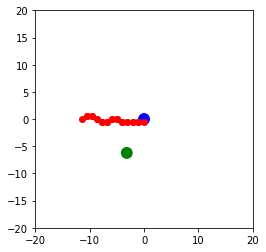

 54%|█████████████████████████████████████▉                                | 271000/500000 [3:26:28<3:19:42, 19.11it/s]

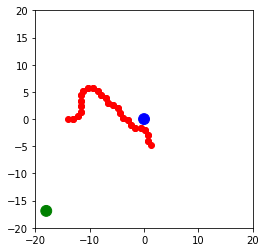

 54%|██████████████████████████████████████                                | 271999/500000 [3:27:13<2:33:46, 24.71it/s]

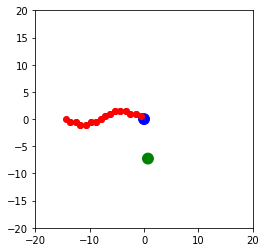

 55%|██████████████████████████████████████▏                               | 273000/500000 [3:28:01<3:02:59, 20.67it/s]

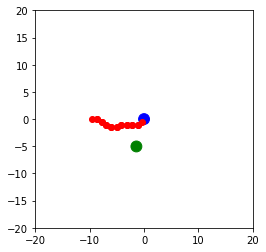

 55%|██████████████████████████████████████▎                               | 273999/500000 [3:28:46<3:01:38, 20.74it/s]

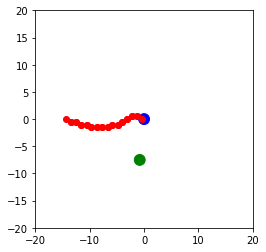

 55%|██████████████████████████████████████▍                               | 274999/500000 [3:29:33<2:55:33, 21.36it/s]

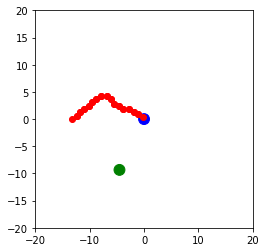

 55%|██████████████████████████████████████▋                               | 275998/500000 [3:30:20<2:41:41, 23.09it/s]

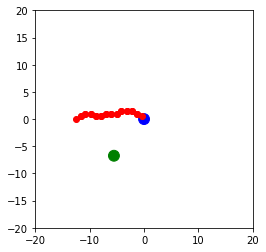

 55%|██████████████████████████████████████▊                               | 276999/500000 [3:31:06<2:35:30, 23.90it/s]

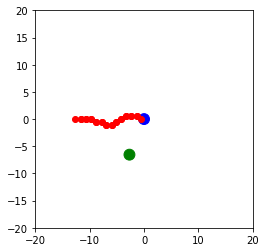

 56%|██████████████████████████████████████▉                               | 277999/500000 [3:31:52<2:39:35, 23.18it/s]

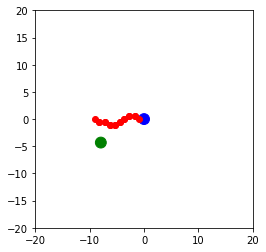

 56%|███████████████████████████████████████                               | 278998/500000 [3:32:40<2:53:58, 21.17it/s]

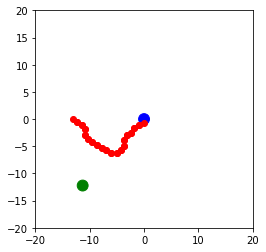

 56%|███████████████████████████████████████▏                              | 279999/500000 [3:33:27<3:15:55, 18.71it/s]

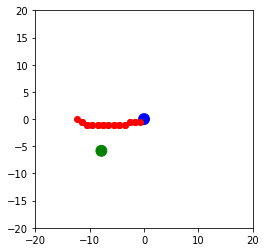

 56%|███████████████████████████████████████▎                              | 281000/500000 [3:34:14<2:48:16, 21.69it/s]

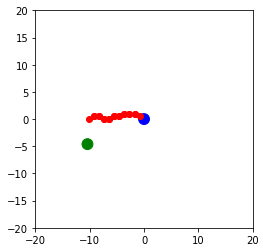

 56%|███████████████████████████████████████▍                              | 282000/500000 [3:35:00<3:08:20, 19.29it/s]

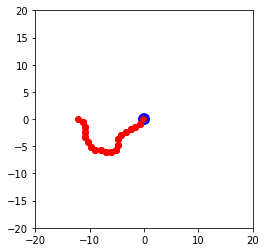

 57%|███████████████████████████████████████▌                              | 282999/500000 [3:35:45<2:33:03, 23.63it/s]

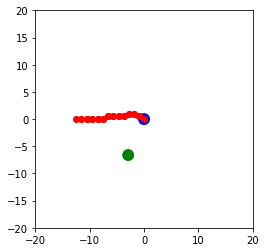

 57%|███████████████████████████████████████▊                              | 283998/500000 [3:36:30<2:30:14, 23.96it/s]

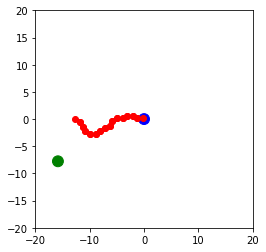

 57%|███████████████████████████████████████▉                              | 284999/500000 [3:37:15<2:28:33, 24.12it/s]

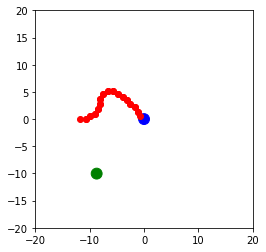

 57%|████████████████████████████████████████                              | 286000/500000 [3:38:00<2:33:17, 23.27it/s]

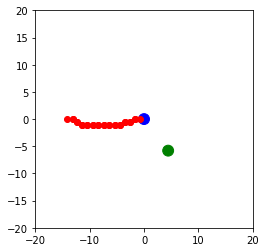

 57%|████████████████████████████████████████▏                             | 286998/500000 [3:38:44<2:12:48, 26.73it/s]

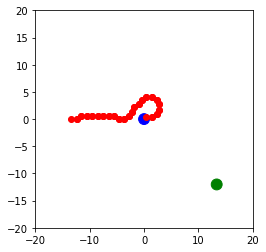

 58%|████████████████████████████████████████▎                             | 288000/500000 [3:39:29<2:31:27, 23.33it/s]

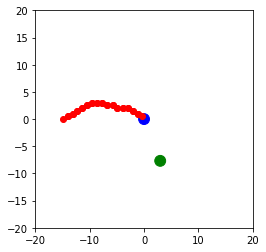

 58%|████████████████████████████████████████▍                             | 288998/500000 [3:40:14<2:33:15, 22.95it/s]

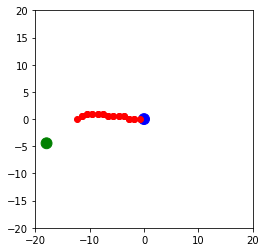

 58%|████████████████████████████████████████▌                             | 289999/500000 [3:41:01<2:35:52, 22.45it/s]

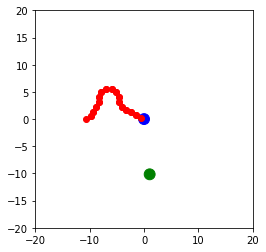

 58%|████████████████████████████████████████▋                             | 290999/500000 [3:41:48<2:42:35, 21.42it/s]

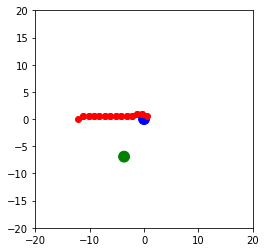

 58%|████████████████████████████████████████▉                             | 292000/500000 [3:42:32<2:12:51, 26.09it/s]

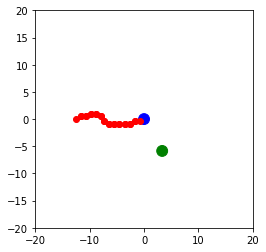

 59%|█████████████████████████████████████████                             | 293000/500000 [3:43:18<2:26:39, 23.52it/s]

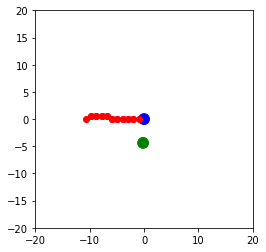

 59%|█████████████████████████████████████████▏                            | 293999/500000 [3:44:04<2:28:53, 23.06it/s]

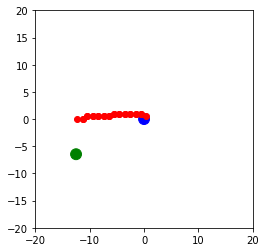

 59%|█████████████████████████████████████████▎                            | 294998/500000 [3:44:50<2:48:24, 20.29it/s]

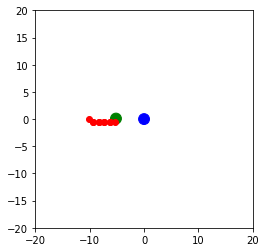

 59%|█████████████████████████████████████████▍                            | 296000/500000 [3:45:35<2:22:42, 23.83it/s]

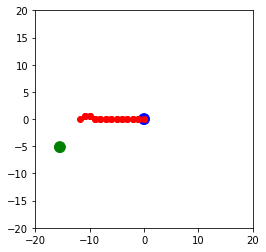

 59%|█████████████████████████████████████████▌                            | 296999/500000 [3:46:23<2:31:51, 22.28it/s]

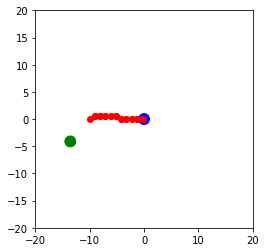

 60%|█████████████████████████████████████████▋                            | 298000/500000 [3:47:10<3:18:08, 16.99it/s]

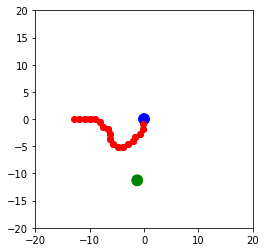

 60%|█████████████████████████████████████████▊                            | 298998/500000 [3:47:53<2:31:08, 22.16it/s]

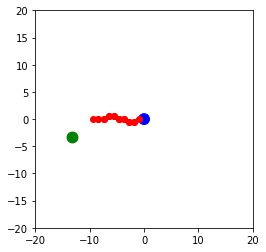

 60%|█████████████████████████████████████████▉                            | 299997/500000 [3:48:36<2:18:51, 24.01it/s]

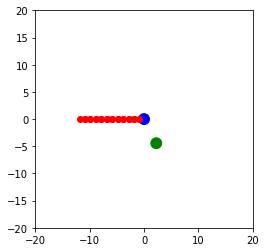

 60%|██████████████████████████████████████████▏                           | 300998/500000 [3:49:19<2:41:05, 20.59it/s]

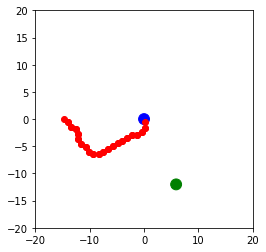

 60%|██████████████████████████████████████████▎                           | 302000/500000 [3:50:02<2:39:01, 20.75it/s]

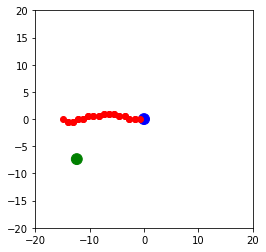

 61%|██████████████████████████████████████████▍                           | 302999/500000 [3:50:45<2:02:51, 26.72it/s]

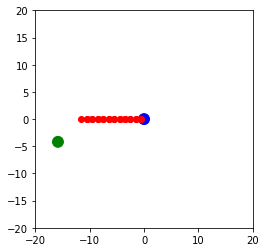

 61%|██████████████████████████████████████████▌                           | 303998/500000 [3:51:28<2:01:43, 26.84it/s]

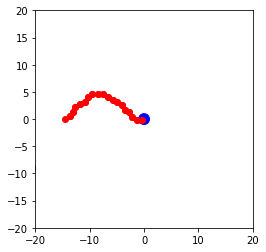

 61%|██████████████████████████████████████████▋                           | 304998/500000 [3:52:10<2:08:25, 25.31it/s]

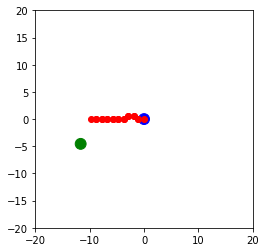

 61%|██████████████████████████████████████████▊                           | 306000/500000 [3:52:53<2:14:32, 24.03it/s]

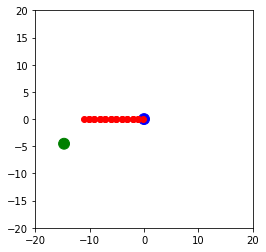

 61%|██████████████████████████████████████████▉                           | 306998/500000 [3:53:34<1:55:26, 27.87it/s]

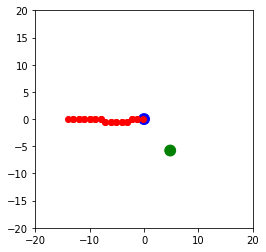

 62%|███████████████████████████████████████████                           | 307999/500000 [3:54:16<2:14:19, 23.82it/s]

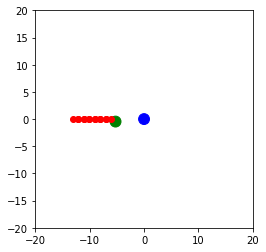

 62%|███████████████████████████████████████████▎                          | 308999/500000 [3:55:01<2:11:11, 24.26it/s]

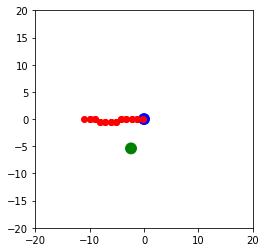

 62%|███████████████████████████████████████████▍                          | 309999/500000 [3:55:45<2:02:14, 25.91it/s]

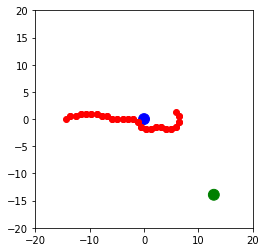

 62%|███████████████████████████████████████████▌                          | 310998/500000 [3:56:27<2:14:13, 23.47it/s]

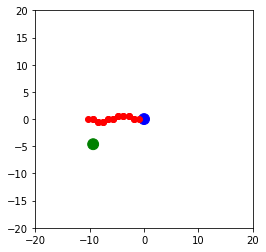

 62%|███████████████████████████████████████████▋                          | 312000/500000 [3:57:11<2:31:38, 20.66it/s]

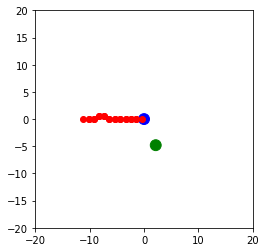

 63%|███████████████████████████████████████████▊                          | 312996/500000 [3:57:54<2:13:18, 23.38it/s]

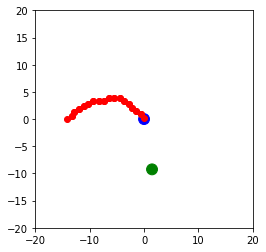

 63%|███████████████████████████████████████████▉                          | 313998/500000 [3:58:40<2:08:59, 24.03it/s]

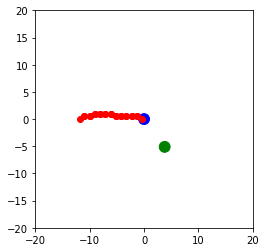

 63%|████████████████████████████████████████████                          | 315000/500000 [3:59:22<2:01:28, 25.38it/s]

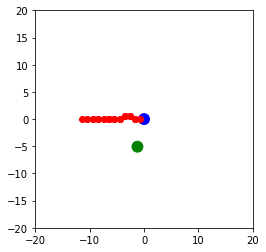

 63%|████████████████████████████████████████████▏                         | 315998/500000 [4:00:04<2:19:43, 21.95it/s]

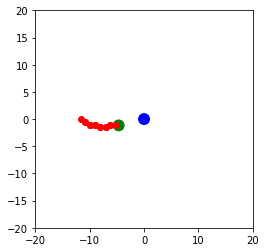

 63%|████████████████████████████████████████████▍                         | 316998/500000 [4:00:46<2:02:11, 24.96it/s]

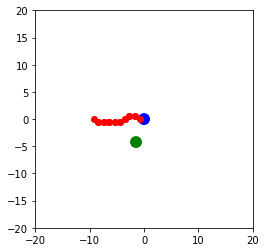

 64%|████████████████████████████████████████████▌                         | 317997/500000 [4:01:30<2:11:20, 23.09it/s]

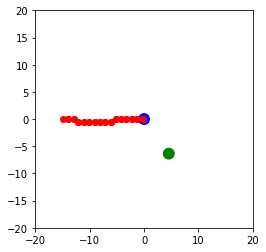

 64%|████████████████████████████████████████████▋                         | 318999/500000 [4:02:13<1:52:18, 26.86it/s]

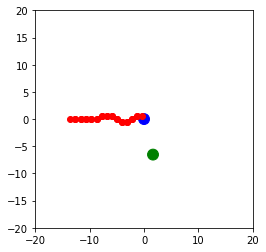

 64%|████████████████████████████████████████████▊                         | 319998/500000 [4:02:57<2:01:48, 24.63it/s]

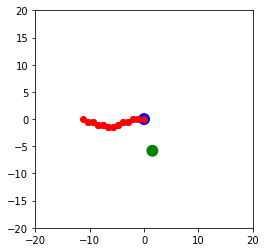

 64%|████████████████████████████████████████████▉                         | 320998/500000 [4:03:40<2:15:05, 22.08it/s]

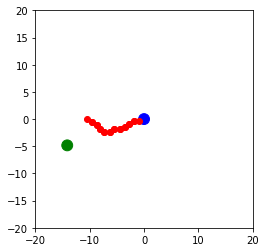

 64%|█████████████████████████████████████████████                         | 321999/500000 [4:04:22<2:04:53, 23.75it/s]

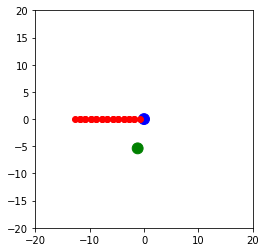

 65%|█████████████████████████████████████████████▏                        | 322999/500000 [4:05:05<2:14:52, 21.87it/s]

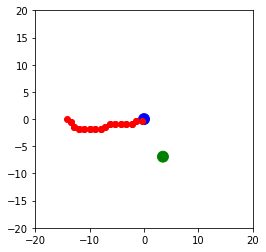

 65%|█████████████████████████████████████████████▎                        | 323998/500000 [4:05:48<2:11:26, 22.32it/s]

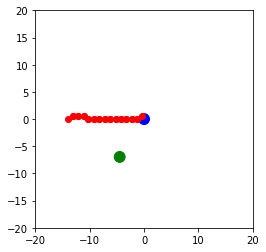

 65%|█████████████████████████████████████████████▍                        | 324999/500000 [4:06:29<1:53:01, 25.81it/s]

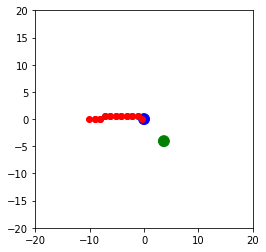

 65%|█████████████████████████████████████████████▋                        | 325999/500000 [4:07:11<2:15:16, 21.44it/s]

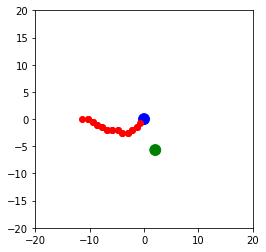

 65%|█████████████████████████████████████████████▊                        | 326998/500000 [4:07:57<2:19:18, 20.70it/s]

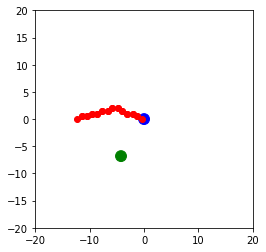

 66%|█████████████████████████████████████████████▉                        | 327999/500000 [4:08:41<2:26:34, 19.56it/s]

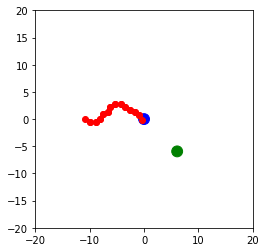

 66%|██████████████████████████████████████████████                        | 328999/500000 [4:09:24<2:38:27, 17.99it/s]

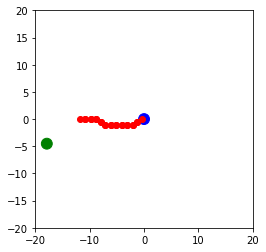

 66%|██████████████████████████████████████████████▏                       | 329998/500000 [4:10:10<2:05:58, 22.49it/s]

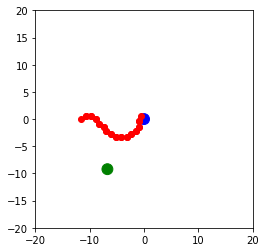

 66%|██████████████████████████████████████████████▎                       | 331000/500000 [4:10:52<1:53:15, 24.87it/s]

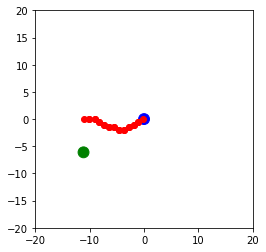

 66%|██████████████████████████████████████████████▍                       | 331999/500000 [4:11:34<2:15:57, 20.59it/s]

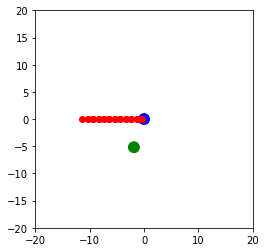

 67%|██████████████████████████████████████████████▌                       | 332998/500000 [4:12:16<2:00:59, 23.00it/s]

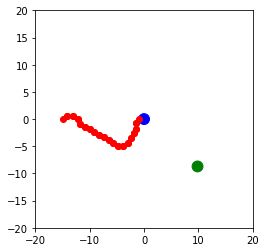

 67%|██████████████████████████████████████████████▊                       | 333998/500000 [4:12:57<1:46:34, 25.96it/s]

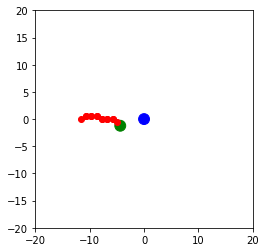

 67%|██████████████████████████████████████████████▉                       | 335000/500000 [4:13:38<1:43:47, 26.49it/s]

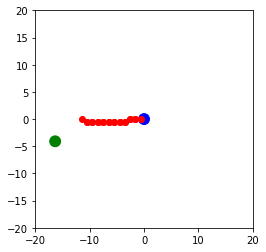

 67%|███████████████████████████████████████████████                       | 335999/500000 [4:14:18<1:52:19, 24.34it/s]

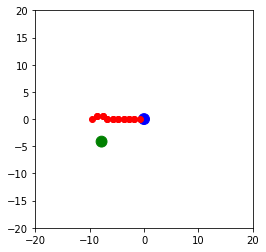

 67%|███████████████████████████████████████████████▏                      | 336999/500000 [4:15:03<1:55:42, 23.48it/s]

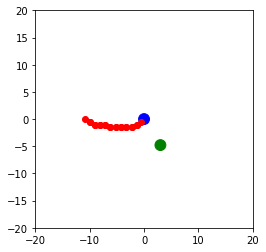

 68%|███████████████████████████████████████████████▎                      | 338000/500000 [4:15:44<1:51:54, 24.13it/s]

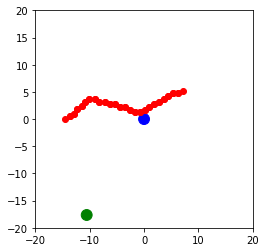

 68%|███████████████████████████████████████████████▍                      | 338999/500000 [4:16:27<1:50:28, 24.29it/s]

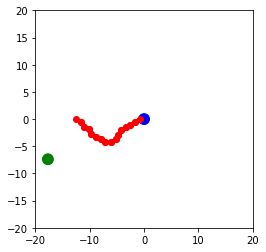

 68%|███████████████████████████████████████████████▌                      | 339998/500000 [4:17:08<1:38:22, 27.11it/s]

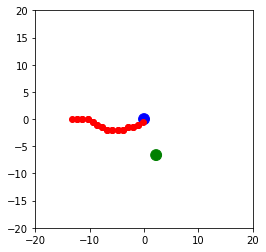

 68%|███████████████████████████████████████████████▋                      | 340998/500000 [4:17:49<1:55:05, 23.03it/s]

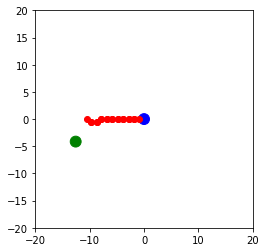

 68%|███████████████████████████████████████████████▉                      | 342000/500000 [4:18:31<1:54:56, 22.91it/s]

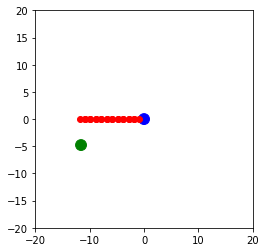

 69%|████████████████████████████████████████████████                      | 342999/500000 [4:19:13<1:54:44, 22.80it/s]

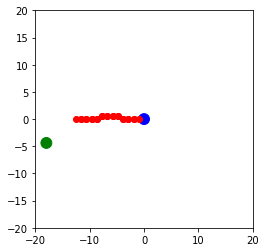

 69%|████████████████████████████████████████████████▏                     | 343998/500000 [4:19:54<1:49:34, 23.73it/s]

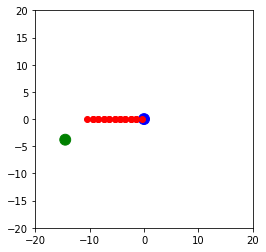

 69%|████████████████████████████████████████████████▎                     | 344999/500000 [4:20:35<1:45:11, 24.56it/s]

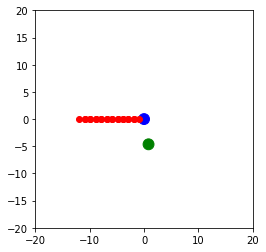

 69%|████████████████████████████████████████████████▍                     | 345999/500000 [4:21:16<1:45:50, 24.25it/s]

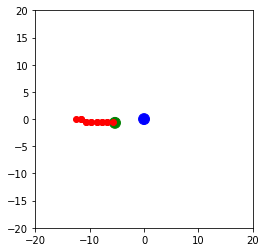

 69%|████████████████████████████████████████████████▌                     | 346998/500000 [4:21:56<1:44:03, 24.51it/s]

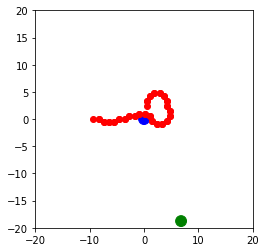

 70%|████████████████████████████████████████████████▋                     | 347999/500000 [4:22:38<1:36:52, 26.15it/s]

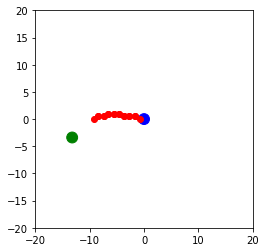

 70%|████████████████████████████████████████████████▊                     | 348997/500000 [4:23:20<1:48:10, 23.27it/s]

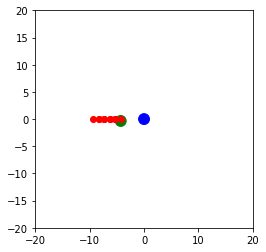

 70%|████████████████████████████████████████████████▉                     | 349999/500000 [4:24:02<2:19:34, 17.91it/s]

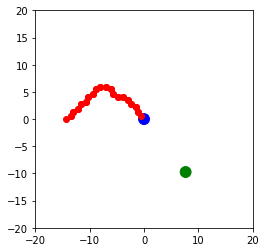

 70%|█████████████████████████████████████████████████▏                    | 351000/500000 [4:24:43<1:52:29, 22.08it/s]

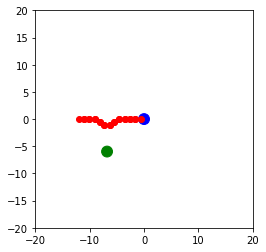

 70%|█████████████████████████████████████████████████▎                    | 351999/500000 [4:25:25<1:47:51, 22.87it/s]

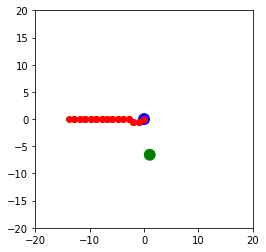

 71%|█████████████████████████████████████████████████▍                    | 352998/500000 [4:26:05<1:43:44, 23.62it/s]

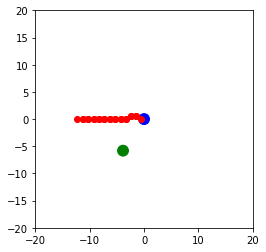

 71%|█████████████████████████████████████████████████▌                    | 353998/500000 [4:26:47<1:48:45, 22.37it/s]

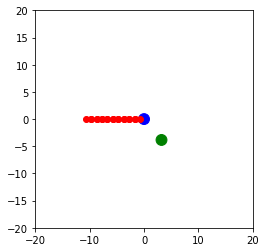

 71%|█████████████████████████████████████████████████▋                    | 354999/500000 [4:27:28<1:35:46, 25.23it/s]

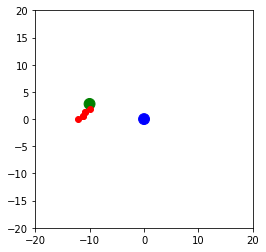

 71%|█████████████████████████████████████████████████▊                    | 355999/500000 [4:28:12<1:49:25, 21.93it/s]

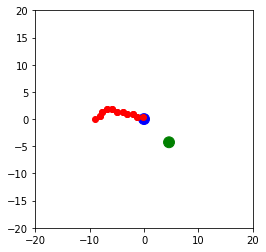

 71%|█████████████████████████████████████████████████▉                    | 356998/500000 [4:28:53<1:32:46, 25.69it/s]

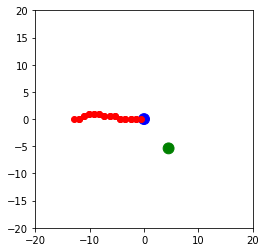

 72%|██████████████████████████████████████████████████                    | 357998/500000 [4:29:34<1:43:15, 22.92it/s]

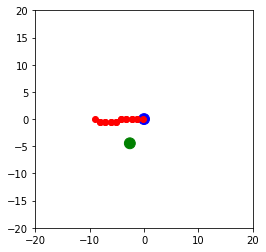

 72%|██████████████████████████████████████████████████▎                   | 358998/500000 [4:30:15<1:50:33, 21.25it/s]

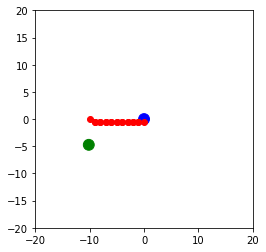

 72%|██████████████████████████████████████████████████▍                   | 359999/500000 [4:31:01<1:57:14, 19.90it/s]

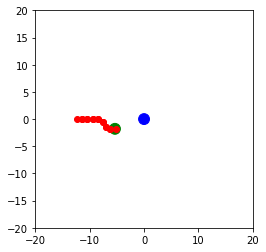

 72%|██████████████████████████████████████████████████▌                   | 361000/500000 [4:31:44<1:26:29, 26.79it/s]

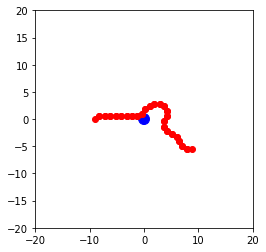

 72%|██████████████████████████████████████████████████▋                   | 362000/500000 [4:32:27<1:32:09, 24.95it/s]

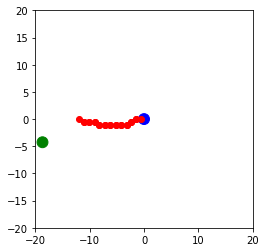

 73%|██████████████████████████████████████████████████▊                   | 362998/500000 [4:33:09<1:41:47, 22.43it/s]

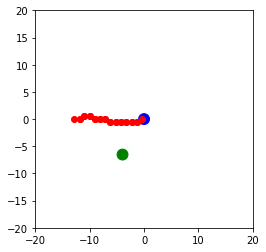

 73%|██████████████████████████████████████████████████▉                   | 363998/500000 [4:33:54<1:45:50, 21.42it/s]

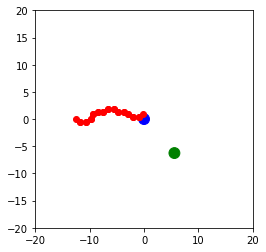

 73%|███████████████████████████████████████████████████                   | 364999/500000 [4:34:36<1:41:08, 22.25it/s]

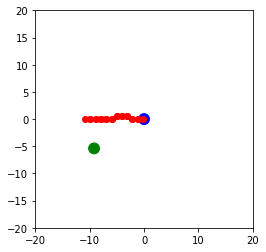

 73%|███████████████████████████████████████████████████▏                  | 365997/500000 [4:35:17<1:39:59, 22.34it/s]

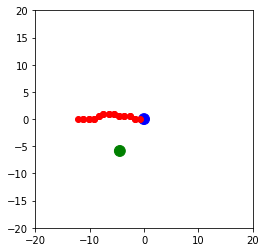

 73%|███████████████████████████████████████████████████▍                  | 366998/500000 [4:35:56<1:34:53, 23.36it/s]

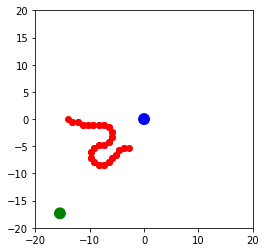

 74%|███████████████████████████████████████████████████▌                  | 368000/500000 [4:36:38<1:18:07, 28.16it/s]

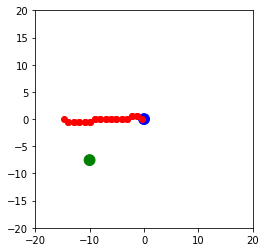

 74%|███████████████████████████████████████████████████▋                  | 368999/500000 [4:37:19<1:30:17, 24.18it/s]

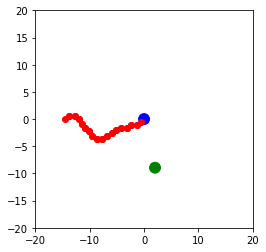

 74%|███████████████████████████████████████████████████▊                  | 370000/500000 [4:38:03<1:43:12, 20.99it/s]

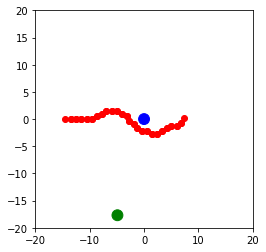

 74%|███████████████████████████████████████████████████▉                  | 370998/500000 [4:38:47<1:26:55, 24.74it/s]

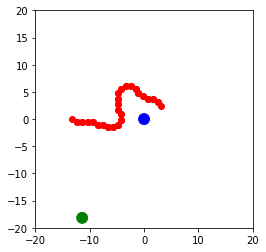

 74%|████████████████████████████████████████████████████                  | 371998/500000 [4:39:33<1:40:40, 21.19it/s]

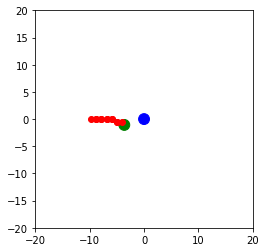

 75%|████████████████████████████████████████████████████▏                 | 373000/500000 [4:40:16<1:30:33, 23.37it/s]

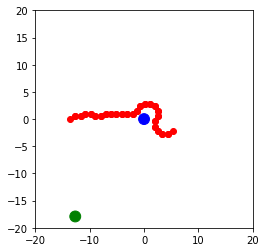

 75%|████████████████████████████████████████████████████▎                 | 373999/500000 [4:40:57<1:31:37, 22.92it/s]

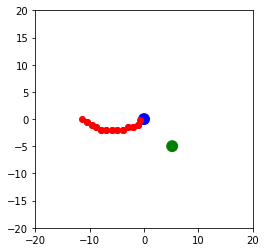

 75%|████████████████████████████████████████████████████▍                 | 374997/500000 [4:41:40<1:14:38, 27.91it/s]

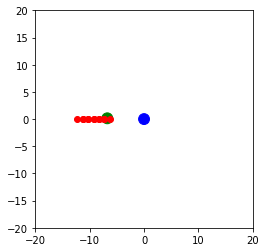

 75%|████████████████████████████████████████████████████▋                 | 375999/500000 [4:42:21<1:30:34, 22.82it/s]

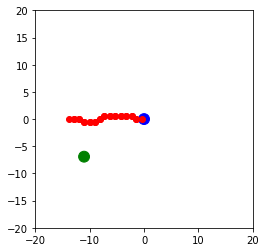

 75%|████████████████████████████████████████████████████▊                 | 376998/500000 [4:43:03<1:29:49, 22.82it/s]

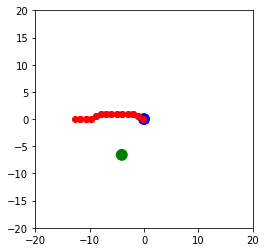

 76%|████████████████████████████████████████████████████▉                 | 378000/500000 [4:43:46<1:25:16, 23.85it/s]

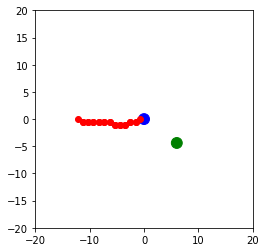

 76%|█████████████████████████████████████████████████████                 | 378999/500000 [4:44:28<1:22:16, 24.51it/s]

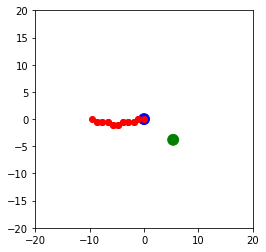

 76%|█████████████████████████████████████████████████████▏                | 379998/500000 [4:45:11<1:21:12, 24.63it/s]

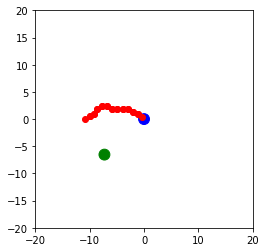

 76%|█████████████████████████████████████████████████████▎                | 380999/500000 [4:45:53<1:26:41, 22.88it/s]

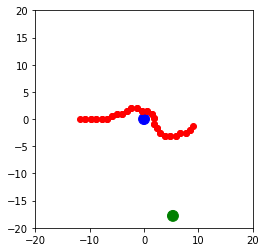

 76%|█████████████████████████████████████████████████████▍                | 382000/500000 [4:46:38<1:02:01, 31.71it/s]

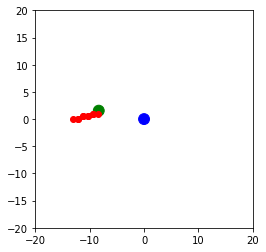

 77%|█████████████████████████████████████████████████████▌                | 382999/500000 [4:47:20<1:24:41, 23.03it/s]

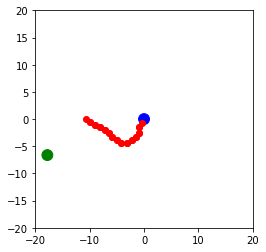

 77%|█████████████████████████████████████████████████████▊                | 383999/500000 [4:48:02<1:32:58, 20.80it/s]

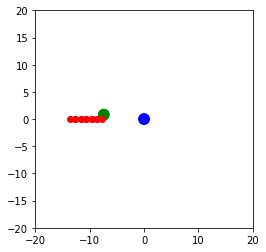

 77%|█████████████████████████████████████████████████████▉                | 384999/500000 [4:48:44<1:14:47, 25.63it/s]

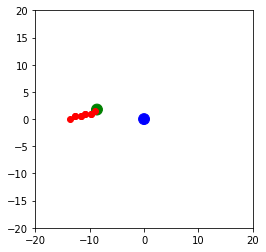

 77%|██████████████████████████████████████████████████████                | 385999/500000 [4:49:25<1:15:00, 25.33it/s]

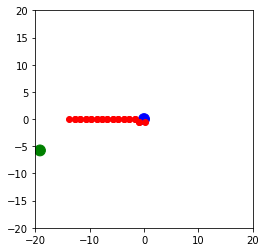

 77%|██████████████████████████████████████████████████████▏               | 386999/500000 [4:50:07<1:17:42, 24.23it/s]

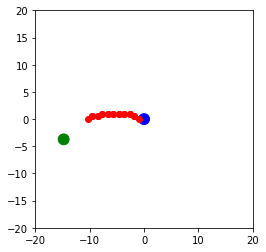

 78%|██████████████████████████████████████████████████████▎               | 387998/500000 [4:50:51<1:07:54, 27.49it/s]

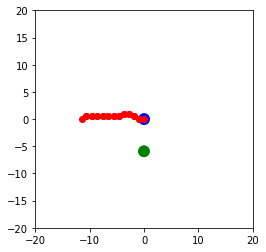

 78%|██████████████████████████████████████████████████████▍               | 389000/500000 [4:51:35<1:06:45, 27.71it/s]

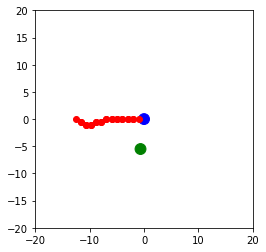

 78%|██████████████████████████████████████████████████████▌               | 389997/500000 [4:52:16<1:05:03, 28.18it/s]

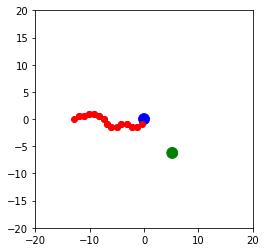

 78%|██████████████████████████████████████████████████████▋               | 390998/500000 [4:52:59<1:20:16, 22.63it/s]

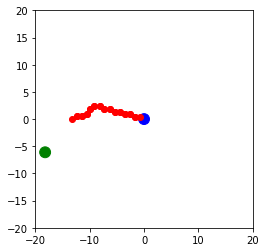

 78%|██████████████████████████████████████████████████████▉               | 391997/500000 [4:53:49<1:23:26, 21.57it/s]

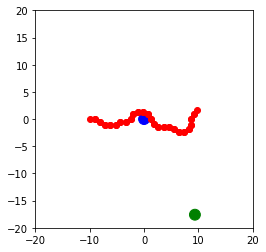

 79%|███████████████████████████████████████████████████████               | 392998/500000 [4:54:42<1:17:38, 22.97it/s]

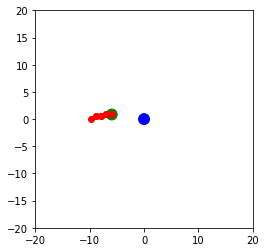

 79%|███████████████████████████████████████████████████████▏              | 394000/500000 [4:55:24<1:23:53, 21.06it/s]

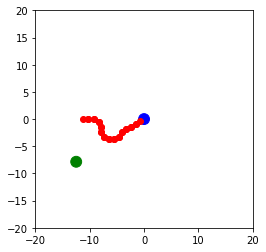

 79%|███████████████████████████████████████████████████████▎              | 394997/500000 [4:56:06<1:18:45, 22.22it/s]

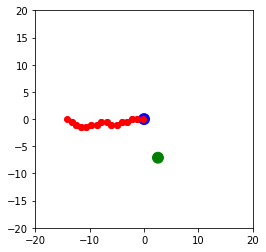

 79%|███████████████████████████████████████████████████████▍              | 396000/500000 [4:56:48<1:07:12, 25.79it/s]

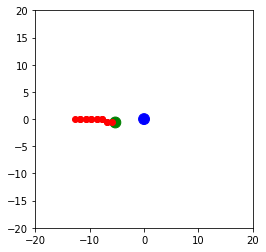

 79%|███████████████████████████████████████████████████████▌              | 396998/500000 [4:57:29<1:06:30, 25.81it/s]

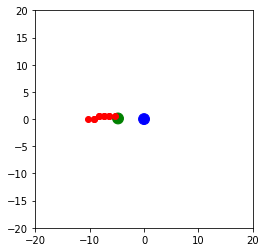

 80%|███████████████████████████████████████████████████████▋              | 397998/500000 [4:58:10<1:21:35, 20.84it/s]

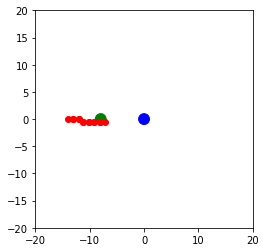

 80%|███████████████████████████████████████████████████████▊              | 399000/500000 [4:58:52<1:09:34, 24.19it/s]

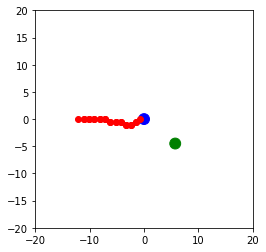

 80%|████████████████████████████████████████████████████████              | 400000/500000 [4:59:40<1:12:31, 22.98it/s]

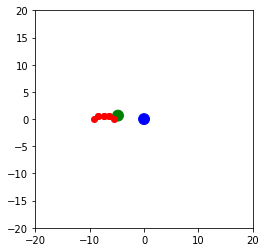

 80%|████████████████████████████████████████████████████████▏             | 400997/500000 [5:00:21<1:01:40, 26.75it/s]

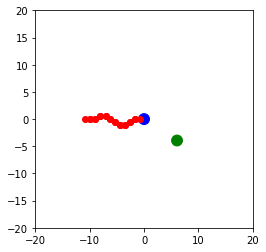

 80%|████████████████████████████████████████████████████████▎             | 401999/500000 [5:01:03<1:05:40, 24.87it/s]

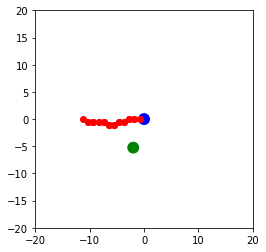

 81%|████████████████████████████████████████████████████████▍             | 402998/500000 [5:01:45<1:10:38, 22.89it/s]

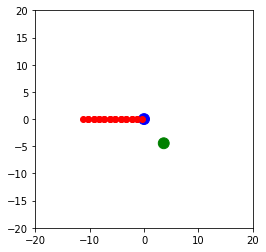

 81%|████████████████████████████████████████████████████████▌             | 404000/500000 [5:02:27<1:06:36, 24.02it/s]

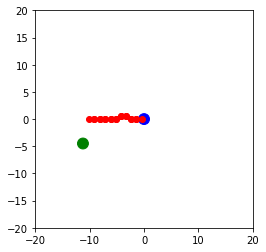

 81%|██████████████████████████████████████████████████████████▎             | 405000/500000 [5:03:08<59:33, 26.59it/s]

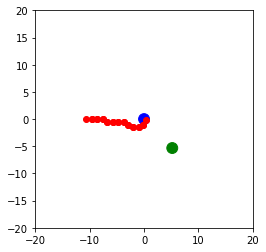

 81%|████████████████████████████████████████████████████████▊             | 406000/500000 [5:03:49<1:06:26, 23.58it/s]

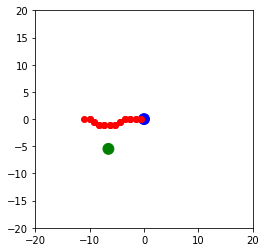

 81%|██████████████████████████████████████████████████████████▌             | 406999/500000 [5:04:30<56:01, 27.67it/s]

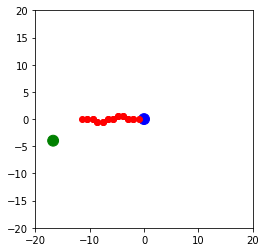

 82%|█████████████████████████████████████████████████████████             | 407998/500000 [5:05:10<1:01:13, 25.04it/s]

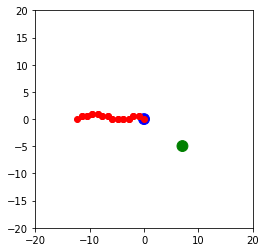

 82%|█████████████████████████████████████████████████████████▎            | 408999/500000 [5:05:53<1:01:05, 24.83it/s]

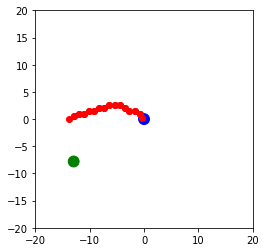

 82%|█████████████████████████████████████████████████████████▍            | 410000/500000 [5:06:37<1:06:49, 22.45it/s]

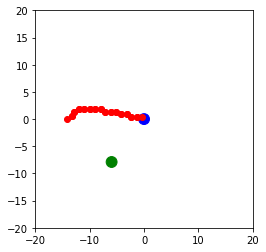

 82%|███████████████████████████████████████████████████████████▏            | 410999/500000 [5:07:21<58:10, 25.50it/s]

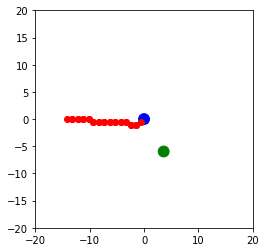

 82%|█████████████████████████████████████████████████████████▋            | 411998/500000 [5:08:02<1:06:48, 21.95it/s]

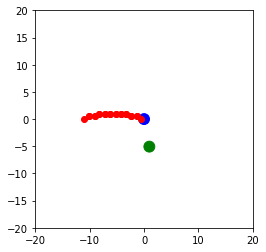

 83%|█████████████████████████████████████████████████████████▊            | 412998/500000 [5:08:43<1:06:47, 21.71it/s]

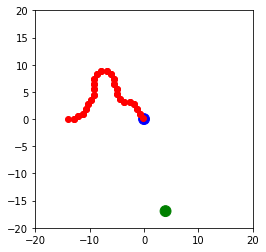

 83%|███████████████████████████████████████████████████████████▌            | 414000/500000 [5:09:25<56:24, 25.41it/s]

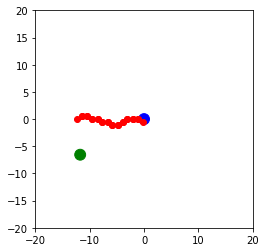

 83%|███████████████████████████████████████████████████████████▊            | 414997/500000 [5:10:08<49:06, 28.85it/s]

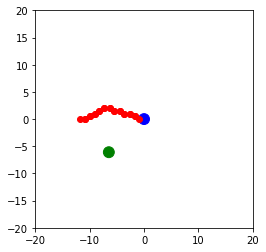

 83%|███████████████████████████████████████████████████████████▉            | 415998/500000 [5:10:50<56:39, 24.71it/s]

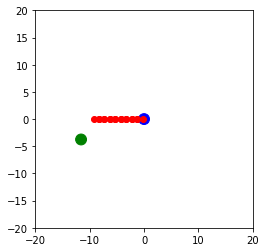

 83%|██████████████████████████████████████████████████████████▍           | 416997/500000 [5:11:33<1:04:11, 21.55it/s]

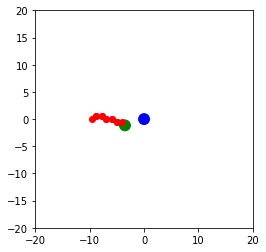

 84%|████████████████████████████████████████████████████████████▏           | 418000/500000 [5:12:15<59:59, 22.78it/s]

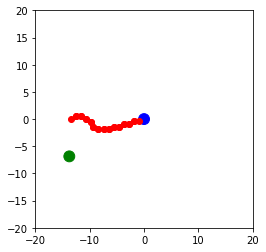

 84%|████████████████████████████████████████████████████████████▎           | 418998/500000 [5:12:56<51:44, 26.09it/s]

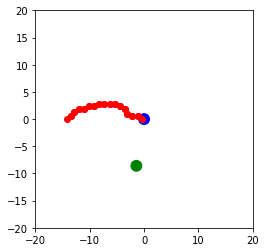

 84%|████████████████████████████████████████████████████████████▍           | 420000/500000 [5:13:38<52:45, 25.27it/s]

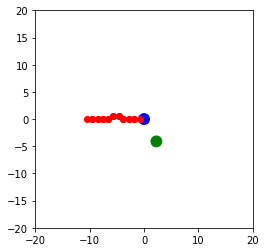

 84%|████████████████████████████████████████████████████████████▌           | 420999/500000 [5:14:19<55:13, 23.84it/s]

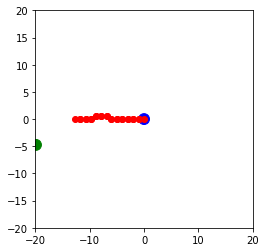

 84%|████████████████████████████████████████████████████████████▊           | 422000/500000 [5:15:02<56:39, 22.94it/s]

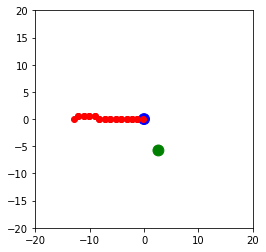

 85%|████████████████████████████████████████████████████████████▉           | 422999/500000 [5:15:43<52:05, 24.64it/s]

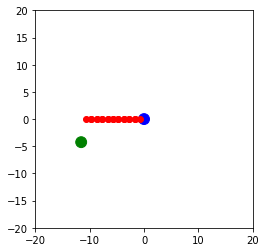

 85%|███████████████████████████████████████████████████████████▎          | 424000/500000 [5:16:25<1:03:55, 19.82it/s]

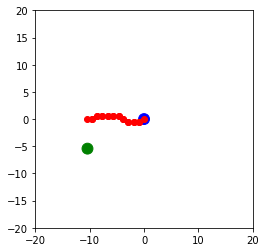

 85%|███████████████████████████████████████████████████████████▌          | 425000/500000 [5:17:08<1:06:53, 18.68it/s]

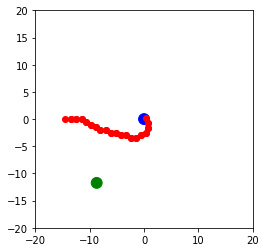

 85%|█████████████████████████████████████████████████████████████▎          | 426000/500000 [5:17:49<49:57, 24.69it/s]

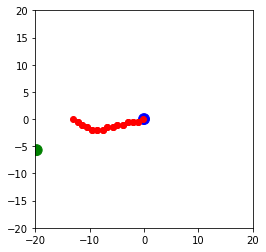

 85%|█████████████████████████████████████████████████████████████▍          | 426998/500000 [5:18:31<56:25, 21.56it/s]

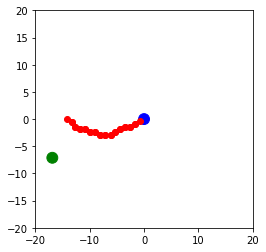

 86%|█████████████████████████████████████████████████████████████▋          | 427998/500000 [5:19:13<54:50, 21.88it/s]

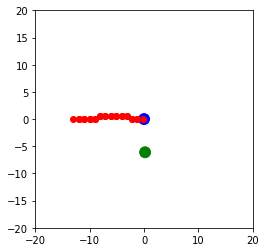

 86%|█████████████████████████████████████████████████████████████▊          | 428999/500000 [5:19:56<51:27, 23.00it/s]

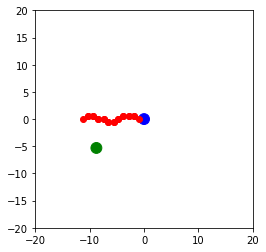

 86%|█████████████████████████████████████████████████████████████▉          | 429999/500000 [5:20:40<45:23, 25.70it/s]

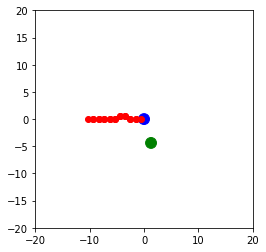

 86%|██████████████████████████████████████████████████████████████          | 431000/500000 [5:21:24<44:48, 25.66it/s]

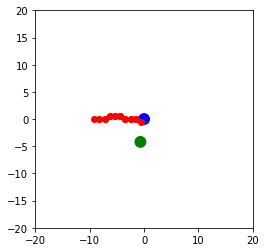

 86%|██████████████████████████████████████████████████████████████▏         | 432000/500000 [5:22:06<44:26, 25.51it/s]

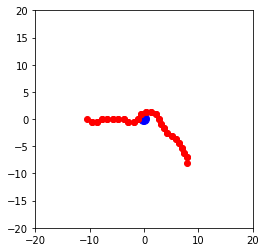

 87%|██████████████████████████████████████████████████████████████▎         | 432999/500000 [5:22:47<44:46, 24.94it/s]

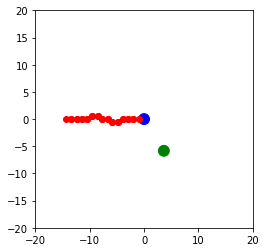

 87%|██████████████████████████████████████████████████████████████▍         | 433999/500000 [5:23:29<46:20, 23.73it/s]

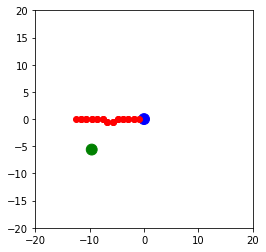

 87%|██████████████████████████████████████████████████████████████▋         | 434997/500000 [5:24:11<39:40, 27.30it/s]

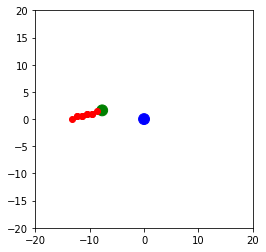

 87%|██████████████████████████████████████████████████████████████▊         | 435997/500000 [5:24:53<44:30, 23.97it/s]

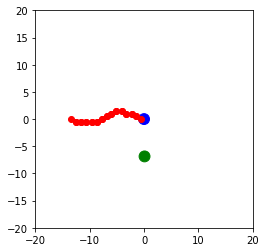

 87%|██████████████████████████████████████████████████████████████▉         | 436998/500000 [5:25:37<44:06, 23.81it/s]

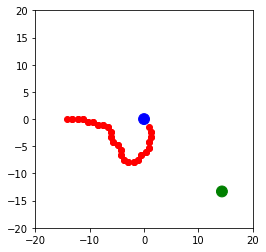

 88%|███████████████████████████████████████████████████████████████         | 437999/500000 [5:26:21<45:54, 22.51it/s]

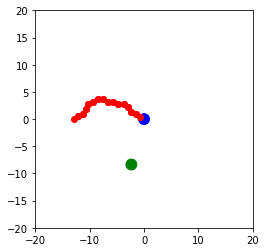

 88%|███████████████████████████████████████████████████████████████▏        | 439000/500000 [5:27:05<46:39, 21.79it/s]

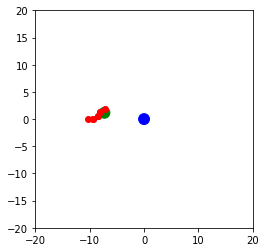

 88%|███████████████████████████████████████████████████████████████▎        | 439998/500000 [5:27:47<44:10, 22.64it/s]

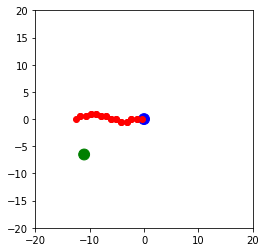

 88%|███████████████████████████████████████████████████████████████▌        | 441000/500000 [5:28:31<42:55, 22.91it/s]

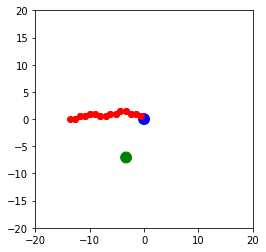

 88%|███████████████████████████████████████████████████████████████▋        | 442000/500000 [5:29:11<38:38, 25.01it/s]

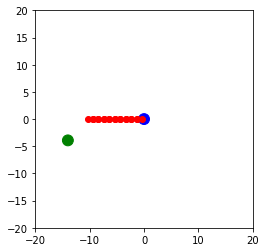

 89%|███████████████████████████████████████████████████████████████▊        | 442998/500000 [5:29:53<38:51, 24.45it/s]

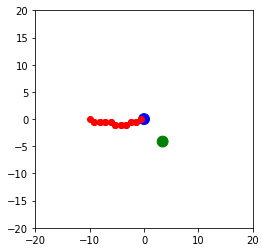

 89%|███████████████████████████████████████████████████████████████▉        | 443998/500000 [5:30:36<40:08, 23.26it/s]

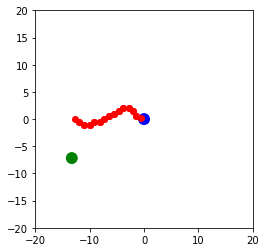

 89%|████████████████████████████████████████████████████████████████        | 445000/500000 [5:31:19<39:53, 22.98it/s]

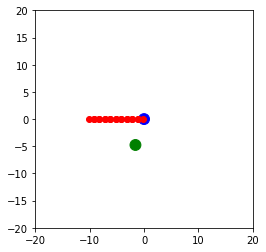

 89%|████████████████████████████████████████████████████████████████▏       | 446000/500000 [5:32:00<37:42, 23.87it/s]

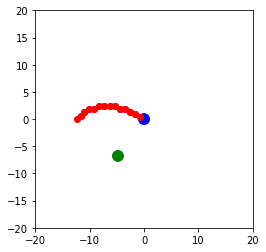

 89%|████████████████████████████████████████████████████████████████▎       | 447000/500000 [5:32:42<35:34, 24.82it/s]

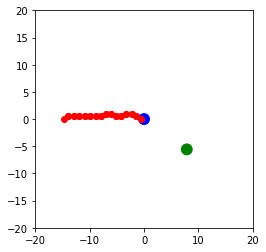

 90%|████████████████████████████████████████████████████████████████▌       | 447999/500000 [5:33:24<38:48, 22.33it/s]

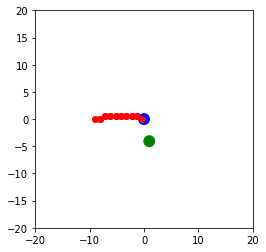

 90%|████████████████████████████████████████████████████████████████▋       | 448999/500000 [5:34:08<39:10, 21.69it/s]

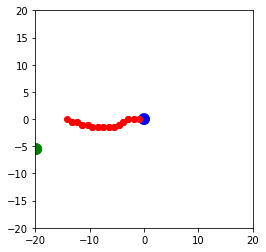

 90%|████████████████████████████████████████████████████████████████▊       | 450000/500000 [5:34:53<39:18, 21.20it/s]

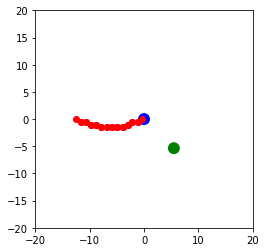

 90%|████████████████████████████████████████████████████████████████▉       | 450998/500000 [5:35:37<36:27, 22.40it/s]

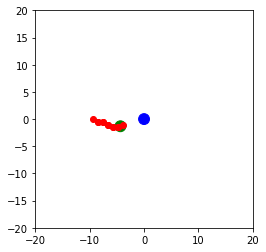

 90%|█████████████████████████████████████████████████████████████████       | 451998/500000 [5:36:23<38:00, 21.05it/s]

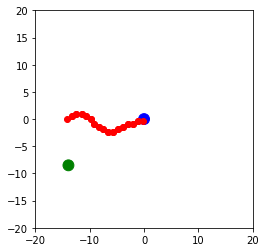

 91%|█████████████████████████████████████████████████████████████████▏      | 452998/500000 [5:37:10<44:52, 17.46it/s]

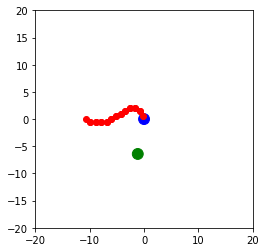

 91%|█████████████████████████████████████████████████████████████████▍      | 454000/500000 [5:37:56<31:44, 24.15it/s]

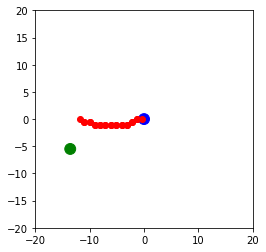

 91%|█████████████████████████████████████████████████████████████████▌      | 455000/500000 [5:38:41<32:44, 22.91it/s]

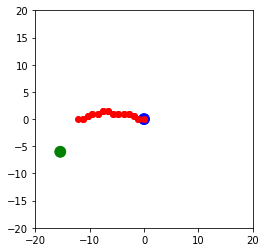

 91%|█████████████████████████████████████████████████████████████████▋      | 455998/500000 [5:39:26<33:16, 22.04it/s]

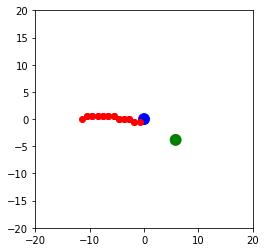

 91%|█████████████████████████████████████████████████████████████████▊      | 456998/500000 [5:40:12<33:26, 21.43it/s]

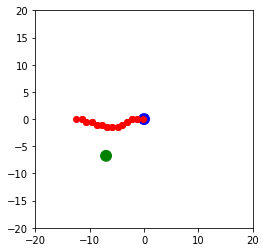

 92%|█████████████████████████████████████████████████████████████████▉      | 458000/500000 [5:40:56<38:32, 18.16it/s]

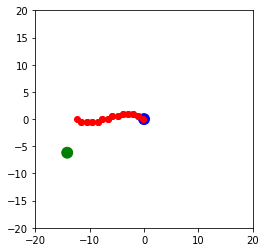

 92%|██████████████████████████████████████████████████████████████████      | 458999/500000 [5:41:43<35:27, 19.27it/s]

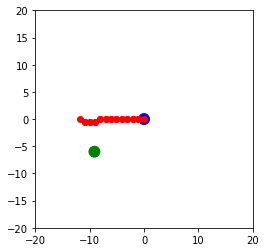

 92%|██████████████████████████████████████████████████████████████████▏     | 459998/500000 [5:42:31<28:36, 23.31it/s]

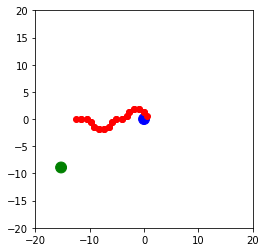

 92%|██████████████████████████████████████████████████████████████████▍     | 460998/500000 [5:43:16<28:18, 22.97it/s]

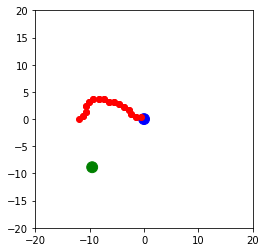

 92%|██████████████████████████████████████████████████████████████████▌     | 461998/500000 [5:44:04<30:35, 20.71it/s]

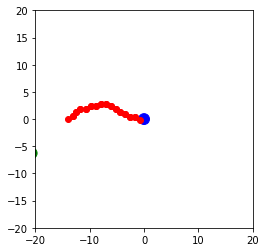

 93%|██████████████████████████████████████████████████████████████████▋     | 463000/500000 [5:44:47<25:28, 24.21it/s]

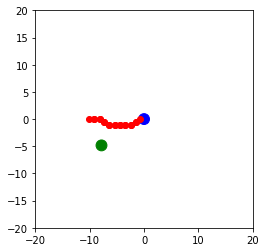

 93%|██████████████████████████████████████████████████████████████████▊     | 463999/500000 [5:45:32<29:43, 20.18it/s]

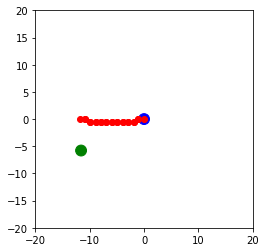

 93%|██████████████████████████████████████████████████████████████████▉     | 464998/500000 [5:46:15<31:02, 18.79it/s]

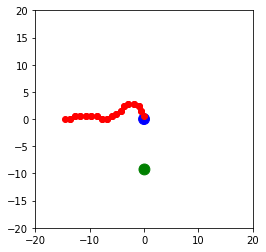

 93%|███████████████████████████████████████████████████████████████████     | 465999/500000 [5:47:03<27:35, 20.53it/s]

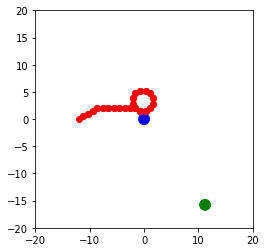

 93%|███████████████████████████████████████████████████████████████████▏    | 466999/500000 [5:47:47<25:08, 21.88it/s]

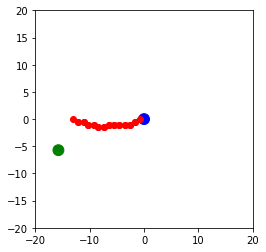

 94%|███████████████████████████████████████████████████████████████████▍    | 467999/500000 [5:48:32<25:32, 20.88it/s]

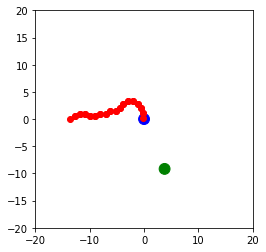

 94%|███████████████████████████████████████████████████████████████████▌    | 469000/500000 [5:49:16<25:45, 20.06it/s]

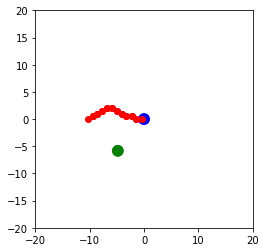

 94%|███████████████████████████████████████████████████████████████████▋    | 470000/500000 [5:49:59<21:12, 23.57it/s]

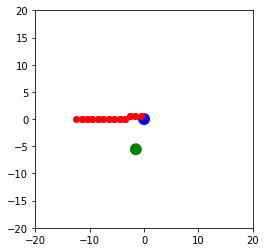

 94%|███████████████████████████████████████████████████████████████████▊    | 470999/500000 [5:50:44<21:19, 22.67it/s]

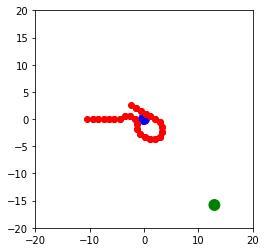

 94%|███████████████████████████████████████████████████████████████████▉    | 471999/500000 [5:51:30<23:56, 19.49it/s]

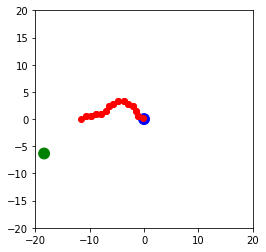

 95%|████████████████████████████████████████████████████████████████████    | 473000/500000 [5:52:18<20:56, 21.49it/s]

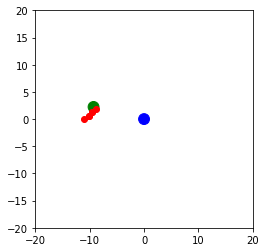

 95%|████████████████████████████████████████████████████████████████████▎   | 473998/500000 [5:53:03<21:39, 20.01it/s]

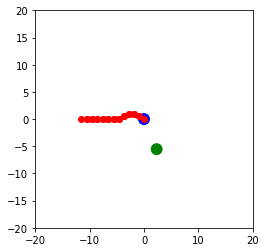

 95%|████████████████████████████████████████████████████████████████████▍   | 475000/500000 [5:53:50<21:52, 19.04it/s]

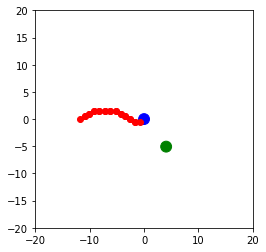

 95%|████████████████████████████████████████████████████████████████████▌   | 475998/500000 [5:54:41<19:25, 20.59it/s]

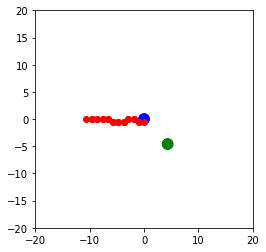

 95%|████████████████████████████████████████████████████████████████████▋   | 476998/500000 [5:55:29<20:10, 19.01it/s]

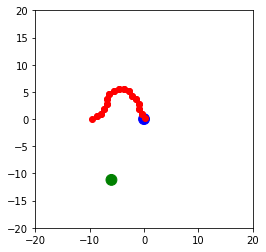

 96%|████████████████████████████████████████████████████████████████████▊   | 477998/500000 [5:56:16<15:23, 23.82it/s]

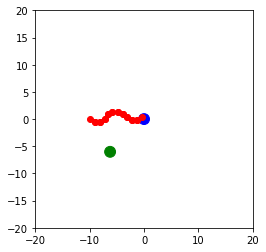

 96%|████████████████████████████████████████████████████████████████████▉   | 478998/500000 [5:57:06<20:07, 17.40it/s]

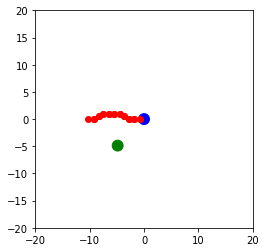

 96%|█████████████████████████████████████████████████████████████████████   | 480000/500000 [5:57:57<19:44, 16.88it/s]

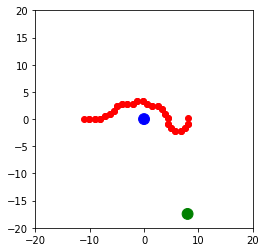

 96%|█████████████████████████████████████████████████████████████████████▎  | 480998/500000 [5:58:46<19:05, 16.59it/s]

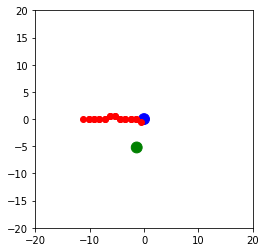

 96%|█████████████████████████████████████████████████████████████████████▍  | 482000/500000 [5:59:34<15:30, 19.35it/s]

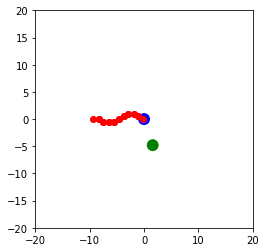

 97%|█████████████████████████████████████████████████████████████████████▌  | 482999/500000 [6:00:24<15:10, 18.67it/s]

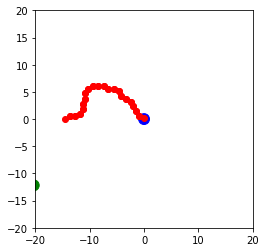

 97%|█████████████████████████████████████████████████████████████████████▋  | 483999/500000 [6:01:11<11:44, 22.72it/s]

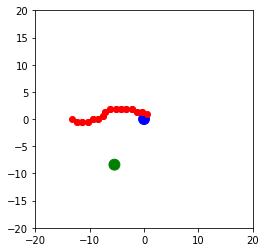

 97%|█████████████████████████████████████████████████████████████████████▊  | 484998/500000 [6:01:55<11:18, 22.11it/s]

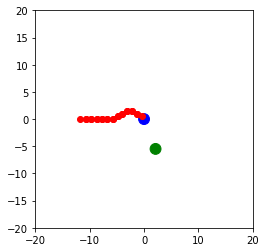

 97%|█████████████████████████████████████████████████████████████████████▉  | 485998/500000 [6:02:40<11:27, 20.36it/s]

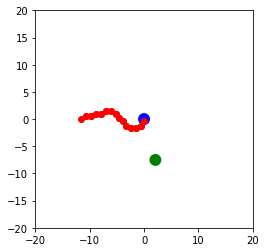

 97%|██████████████████████████████████████████████████████████████████████▏ | 486998/500000 [6:03:29<10:43, 20.20it/s]

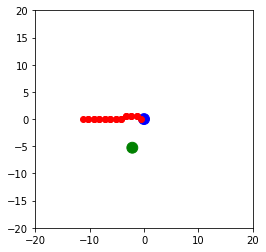

 98%|██████████████████████████████████████████████████████████████████████▎ | 487998/500000 [6:04:14<10:10, 19.67it/s]

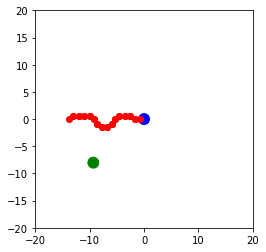

 98%|██████████████████████████████████████████████████████████████████████▍ | 489000/500000 [6:05:00<07:29, 24.46it/s]

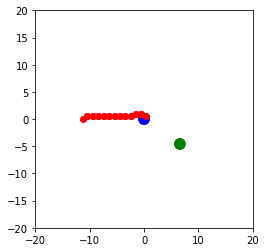

 98%|██████████████████████████████████████████████████████████████████████▌ | 489998/500000 [6:05:43<07:15, 22.98it/s]

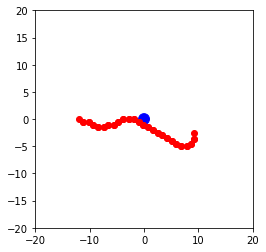

 98%|██████████████████████████████████████████████████████████████████████▋ | 490998/500000 [6:06:29<06:51, 21.90it/s]

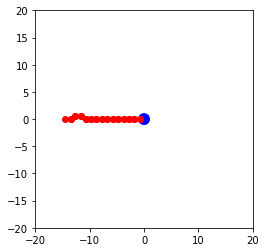

 98%|██████████████████████████████████████████████████████████████████████▊ | 492000/500000 [6:07:14<05:44, 23.25it/s]

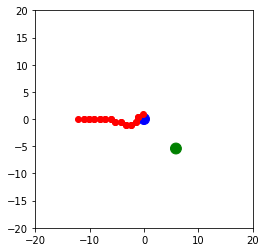

 99%|██████████████████████████████████████████████████████████████████████▉ | 493000/500000 [6:08:02<06:46, 17.21it/s]

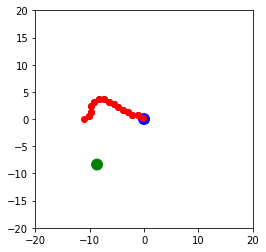

 99%|███████████████████████████████████████████████████████████████████████▏| 493998/500000 [6:08:50<04:37, 21.61it/s]

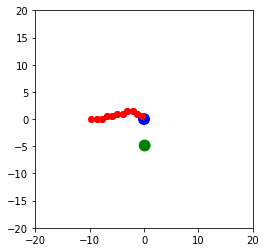

 99%|███████████████████████████████████████████████████████████████████████▎| 494998/500000 [6:09:37<03:23, 24.61it/s]

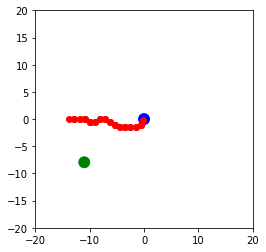

 99%|███████████████████████████████████████████████████████████████████████▍| 496000/500000 [6:10:22<03:23, 19.62it/s]

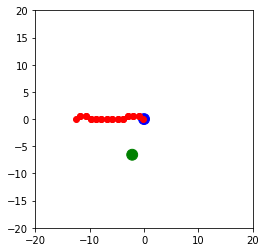

 99%|███████████████████████████████████████████████████████████████████████▌| 496999/500000 [6:11:06<02:15, 22.21it/s]

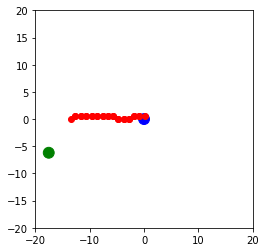

100%|███████████████████████████████████████████████████████████████████████▋| 497999/500000 [6:11:51<01:35, 20.93it/s]

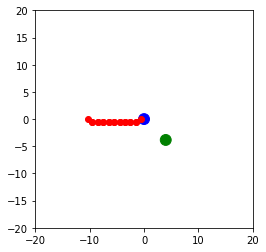

100%|███████████████████████████████████████████████████████████████████████▊| 498998/500000 [6:12:37<00:41, 24.18it/s]

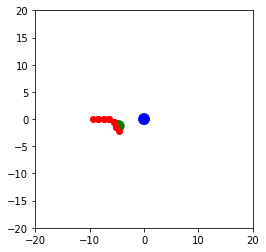

100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [6:13:24<00:00, 22.32it/s]


In [179]:
rewards = []
net = DQN()

def main():
    print("The DQN is collecting experience...")
    step_counter_list = []
    for episode in tqdm.tqdm(range(EPISODES)):
        state = env.reset()
        step_counter = 0
        sum_rew = 0
        while True:
            step_counter +=1
            action = net.choose_action(state)
            next_state, reward, done = env.step(action)
            # reward = reward * 100 if reward > 0 else reward * 5
            sum_rew += reward
            net.store_trans(state, action, reward, next_state)
            if net.memory_counter >= MEMORY_CAPACITY:
                net.learn()
            if done:
                step_counter_list.append(step_counter)
                # print("episode {}, the reward is {}".format(episode, round(reward, 3)))
                rewards.append(sum_rew)
                if episode % 1000 == 0:
                    env.draw_map()
                # net.plot(net.ax, step_counter_list)
                break

            state = next_state
            

if __name__ == '__main__':
    main()

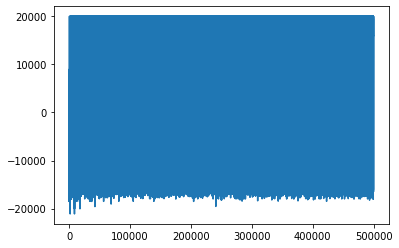

In [114]:
plt.plot(rewards)

In [115]:
m = 0
p = 0
for i in rewards:
    if i < 0:
        m += 1
    else:
        p += 1

In [116]:
m / (m + p)

0.11666

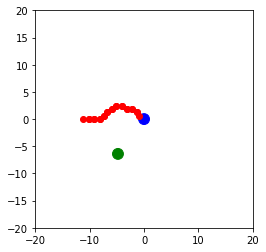

In [117]:
env.draw_map()

In [118]:
print("Running tests")
rewards = []

step_counter_list = []
for episode in tqdm.tqdm(range(EPISODES)):
    state = env.reset()
    step_counter = 0
    sum_rew = 0
    while True:
        step_counter +=1
        action = net.choose_action(state)
        next_state, reward, done = env.step(action)
        sum_rew += reward
        if done:
            rewards.append(sum_rew)
            break

        state = next_state

Running tests


100%|█████████████████████████████████████████████████████████████████████████| 500000/500000 [08:25<00:00, 988.32it/s]


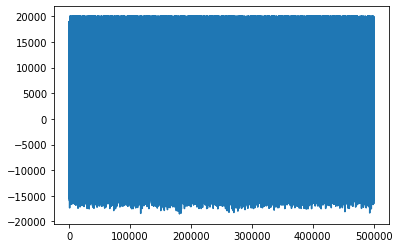

In [119]:
plt.plot(rewards)

In [120]:
m = 0
p = 0
for i in rewards:
    if i < 0:
        m += 1
    else:
        p += 1

In [121]:
m / (m + p)

0.08545

In [ ]:
class QLearningTable:
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        self.actions = actions
        print(self.actions)
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)
        self.q_table_final = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def choose_action(self, observation):
        self.check_state_exist(observation)
        
        if np.random.uniform() < self.epsilon:
            state_action = self.q_table.loc[observation, :]
            state_action = state_action.reindex(np.random.permutation(state_action.index))
            action = state_action.idxmax()
        else:
            action = np.random.choice(self.actions)
        return action

    def learn(self, state, action, reward, next_state):
        self.check_state_exist(next_state)

        q_predict = self.q_table.loc[state, action]

        if next_state != 'goal' or next_state != 'obstacle':
            q_target = reward + self.gamma * self.q_table.loc[next_state, :].max()
        else:
            q_target = reward
        self.q_table.loc[state, action] += self.lr * (q_target - q_predict)

        return self.q_table.loc[state, action]

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            self.q_table = self.q_table.append(
                pd.Series(
                    [0]*len(self.actions),
                    index=self.q_table.columns,
                    name=state,
                )
            )